# Milestone P3

# Pivotal Movies: Catch them if you can!

# Introduction


The history of cinema is shaped by innovation and cycles. A genre is created, while another dives into the abyss of indifference. Life and death, Yin and Yang. And every now and then magic happens: a golden age. Everyone has an uncle that keeps raving about the good ol’ Clint Eastwood Western days (or is that just us?). These golden ages are prime examples of snowball effects, introduced by single movies that stand out of the crowd and shape the future of the movie industry by creating a new trend.

At least this is the assumption on which we base this data project. There are singular movies, that can be identified as being the source of a trend, that produced a concentrated release of movies similar to that singular one. TheWestBobers call these Pivotal Movies.

## Milestone Objectives

In the course of this data story, we will show you our way to identify these Pivotal Movies. Based on several datasets, which provide us with a series of metrics on a broad range of movies, a identification-method has been developed. With this, we are able to discover the Pivotal Movies throughout the history of cinema.

But be warned: Take our results with a good amount of salt - they result from an experimental analysis and therefore are subject to major limitations.



In [1]:
import os

from helpers import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import nltk

import re
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler

from IPython.display import Image

%load_ext autoreload
%autoreload 2

c:\Users\paulr\anaconda3\envs\ada\lib\site-packages\pyspark\pandas\__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


In [2]:
# Data Path
DATA_PATH = '../data/'
MOVIES_FOLDER = DATA_PATH+'MovieSummaries/'
MOVIES_DATASET = MOVIES_FOLDER+"movie.metadata.tsv"

# Load Data
df = pd.read_csv(MOVIES_DATASET, sep='\t', names=['id_wiki','id_freebase','name','date',
                                                  'box_office','runtime','lang','countries','genres'])

# 0) Overview of the data used (Milestone P2) 

In Milestone P2 we explored the CMU movie data in order to have a fist assessment of the potential of our project 

## 0.1) Overall overview of the dataset 

First, let's take a global view of what we have in the CMU movie dataset. We'll explore the dataset's overall structure, key variables, and initial characteristics to better understand the scope and content of the data before delving into specific analyses and preprocessing steps.

In [3]:
print("We have a total number of {} movies in the dataset ".format(len(df)))


We have a total number of 81741 movies in the dataset 


In [4]:
print('Features of the dataset:')
print(df.columns.values)

Features of the dataset:
['id_wiki' 'id_freebase' 'name' 'date' 'box_office' 'runtime' 'lang'
 'countries' 'genres']


- **id_wiki:** This is a unique identifier associated with each movie on Wikipedia.

- **id_freebase:** This is a unique identifier associated with each movie on Freebase. This feature provides no useful information, as databases from Freebase were merged with Wikipedia in 2014.

- **name:** Title of the movie.

- **date:** Date of release of the movie.

- **box_office:** Contains the box office revenue in dollars.

- **runtime:** Duration of the film in minutes.

- **lang:** This column indicates the languages used in the original (VO) movie.

- **countries:** This column is associated with the country of production of the movie.

- **genres:** Genres associated with the film.


Let's see an example with our favorite movie saga: *Twilight*.

But where are our precious movies? As the dataframe contains 80,000 movies, we need to find which ones contain the word "Twilight" in the title name.


In [5]:
result = df[df['name'].str.contains('twilight', case=False, na=False)]
display(' Movie title that contains Twilight \n', result['name'] )

' Movie title that contains Twilight \n'

2673                                     Women of Twilight
3241                              Twilight's Last Gleaming
7447                           Twilight of the Dark Master
9863                                      Twilight Dancers
9912             The Twilight Saga: Breaking Dawn - Part 1
13863    Memories of Berlin: The Twilight of Weimar Cul...
14223                                             Twilight
18376                                       Tokyo Twilight
19856                             Twilight Zone: The Movie
27507                              The Kingdom of Twilight
33617                          Twilight of the Cockroaches
33659                                             Twilight
35389                                     Twilight Theater
41159                                    Twilight of Honor
41604                                 The Twilight Samurai
42224                              Sir Galahad of Twilight
42881                                 Twilight of the Go

In [6]:
print( 'We have a total of {} movie that contain Twilight in their title'.format(len(result)))

We have a total of 29 movie that contain Twilight in their title


That's more than we expected! Anyway, I see my favorite one: *The Twilight Saga: Breaking Dawn - Part 1*. Let's analyze the features of this movie.


In [7]:
FILM_NAME='The Twilight Saga: Breaking Dawn - Part 1'

print('Released date: {} \n' .format(df[
    df['name']==FILM_NAME]['date'].values[0]))

print('Genres: {} \n'.format(df[
    df['name']==FILM_NAME]['genres'].values[0]))

print('Countries of production: {} \n'.format(df[
    df['name']==FILM_NAME]['countries'].values[0]))


print('Box office revenues : {:,.0f}$ \n'.format(df[
    df['name']==FILM_NAME]['box_office'].values[0]))

print('Duration : {:.0f} minutes \n'.format(df[
    df['name']==FILM_NAME]['runtime'].values[0]))

print('Language adaptation :{}' .format(df[
    df['name']==FILM_NAME]['lang'].values[0]))

Released date: 2011-11-16 

Genres: {"/m/07s9rl0": "Drama", "/m/01hmnh": "Fantasy", "/m/03k9fj": "Adventure", "/m/02b5_l": "Teen", "/m/03rzvv": "Romantic fantasy"} 

Countries of production: {"/m/09c7w0": "United States of America"} 

Box office revenues : 705,058,657$ 

Duration : 117 minutes 

Language adaptation :{"/m/02h40lc": "English Language"}


As we can see, some features are not that clean, like **genre, countries, and language adaptation**. These features will need to be treated in the second part.


After examining the features for the film *The Twilight Saga: Breaking Dawn - Part 1*, let's delve into a broader understanding of the dataset. Now, shifting our focus to the entire dataset, we aim to provide a comprehensive overview.


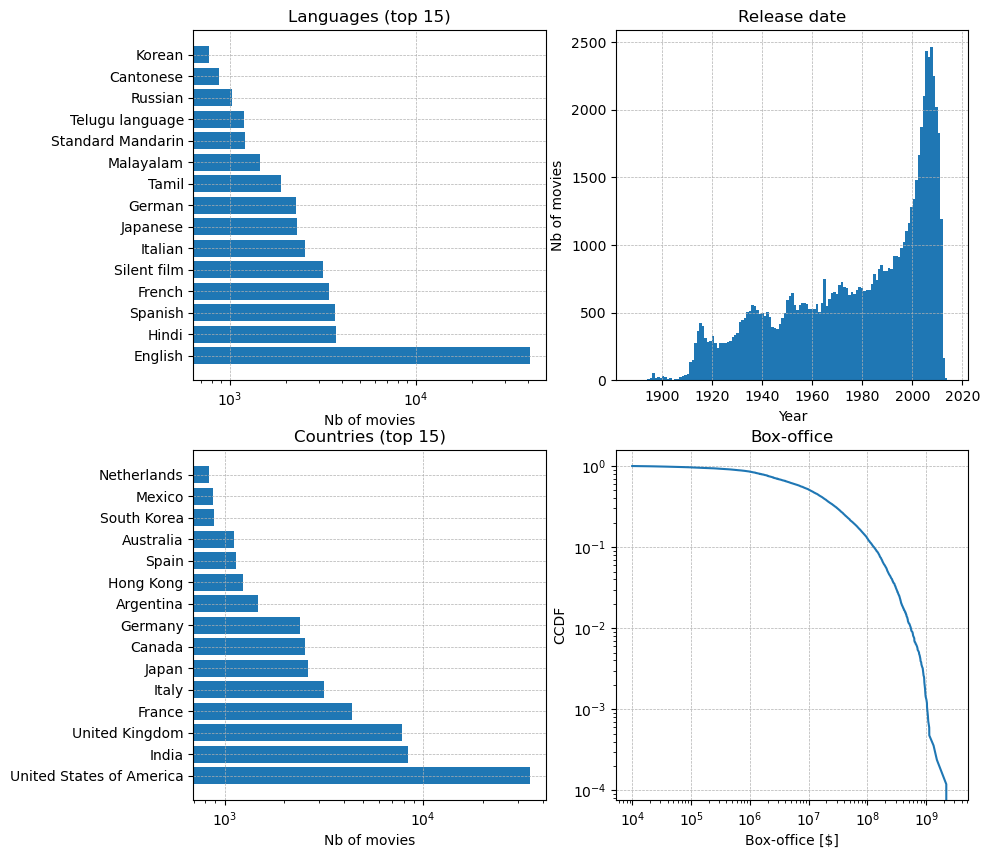

In [8]:
data_viz(df, israw=True)

## 0.2) Cleaning the data 

This part focuses on cleaning the data. Indeed, cleaning data is an important step for accurate data analysis. It ensures the integrity of results, reduces the risk of errors, and promotes consistency in reporting. Clean data enhances data understanding, uncovering valuable insights and patterns. Moreover, it facilitates compatibility with other datasets, mitigates bias, and ensures compliance with industry regulations. In essence, data cleaning is an essential step that contributes to the overall quality and effectiveness of data-driven processes. But first things first, let's make a deep copy of the dataset before filtering.


In [9]:
movies = df.copy()

### i) Removing missing data :

First let's have a look at what is missing in the original dataframe *'df'*

In [10]:
generate_missing_info(df)

,Missing Data (%)
Column,
id_wiki,0.00
id_freebase,0.00
name,0.00
date,8.44
box_office,89.72
runtime,25.02
lang,0.00
countries,0.00
genres,0.00


In order to identify pivotal movies, some features of data are crucial. First is data linked to trend identification. To identify trends for movies, we need two features: the **date of release** and the **genres** of the movie. Then, we remove all movies that have either a missing date feature or a missing genres feature.


In [11]:
# Handle missing values
movies = data_missing(movies)

Now let's check if there are any duplicates. We define a duplicate pair as movies with the same name, release year, and runtime.


In [12]:
check_doublons(movies,['name'],'date','runtime')

Rows with real duplicates: 
                                     name        date  runtime
1412                       Landspeed: CKY        1999      NaN
4856   Indiana Jones and the Last Crusade  1989-05-24    127.0
5356                       Landspeed: CKY        1999      NaN
5872                    Secrets of Nature        1950      NaN
9965                      Little Big Horn  1951-06-15     86.0
13458                    Jeepers Creepers        1939      NaN
16448                 Moscow Strikes Back  1942-02-23     55.0
24940                   Secrets of Nature        1950      NaN
31701                    Facing the Music  1941-10-18     79.0
45846                 Moscow Strikes Back  1942-02-23     55.0
46001                    Jeepers Creepers        1939      NaN
49203  Indiana Jones and the Last Crusade  1989-05-24    127.0
51505                Yours, Mine and Ours  2005-11-23     88.0
61322                     Little Big Horn  1951-06-15     86.0
62250                      

'--------------------------------------------------------------------------------'

Interesting! Looks like we have some duplicates. We'll merge them so that we keep all the relevant information. For example, let's look at the Indiana Jones movie.


In [13]:
display(movies[movies['name'] == 'Indiana Jones and the Last Crusade'])

,id_wiki,id_freebase,name,date,box_office,runtime,lang,countries,genres
4856,3184269,/m/0dnqr,Indiana Jones and the Last Crusade,1989-05-24,NaN,127.0,"{""/m/0349s"": ""Greek Language"", ""/m/04306rv"": ""...","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3m_6"": ""Costume Adventure"", ""/m/02kdv5..."
49203,51888,/m/0h_b6x1,Indiana Jones and the Last Crusade,1989-05-24,474171806.0,127.0,{},{},"{""/m/03k9fj"": ""Adventure""}"


After merging :

In [14]:
movies = fuse_duplicates(movies, col_check=['name'], year='date', runtime='runtime',
                         col_len=['lang', 'countries', 'genres'], col_null=['box_office', 'runtime'])
display(movies[movies['name']=='Indiana Jones and the Last Crusade'])


Fusing duplicates: 
Duplicates fused successfully.
--------------------------------------------------------------------------------


,id_wiki,id_freebase,name,date,box_office,runtime,lang,countries,genres
4452,3184269,/m/0dnqr,Indiana Jones and the Last Crusade,1989-05-24,474171806.0,127.0,"{""/m/0349s"": ""Greek Language"", ""/m/04306rv"": ""...","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3m_6"": ""Costume Adventure"", ""/m/02kdv5..."


In [15]:
print('The remaining values of movies after this step is {}'.format(len(movies)))


The remaining values of movies after this step is 74830


### ii) Changing the features format

Now that the missing data has been dropped, we will address unclear features in the dataset. Building on the example of 'Twilight' from part 1, we observed that the presentation of languages, countries, and genres needed improvement. Let's reorganize and standardize these features for better clarity. Additionally, we'll modify the date format to establish a consistent basis for every film in the dataset.


In [16]:
# Format data types
movies = data_format(movies)

Let's take a look to the refresh features

In [17]:
print('Released date: {} \n' .format( movies[
    movies['name']==FILM_NAME]['date'].values[0]))

print('Genres: {} \n'.format( movies[
    movies['name']==FILM_NAME]['genres'].values[0]))

print('Countries of production: {} \n'.format(    movies[
       movies['name']==FILM_NAME]['countries'].values[0]))
  

print('Language adaptation :{}' .format(movies[
        movies['name']==FILM_NAME]['lang'].values[0]))

Released date: 2011 

Genres: ['Drama', 'Fantasy', 'Adventure', 'Teen', 'Romantic fantasy'] 

Countries of production: ['USA'] 

Language adaptation :['English Language']


Nice! Now we see clearly the genre, countries of production, and language adaptation. Furthermore, we only keep the year the film has been released for our further analysis.

For the sake of simplicity, we rename the column 'date' to 'year' and the column 'box_office' to 'revenue'.


In [18]:
movies.rename(columns={'box_office': 'revenue'}, inplace=True)
movies.rename(columns={'date': 'year'}, inplace=True)


### iii) Boundary definition

To ensure the accuracy of our data for analysis, it is crucial to define boundaries within the 'date' feature. Occasionally, incorrect data may be present, leading to inconsistencies. Let's identify and rectify such errors to maintain data integrity and ensure meaningful analysis.


In [19]:
display(movies[movies['year']<1800][['name','year']])

,name,year
57565,Hunting Season,1010


Turns out the Middle Ages had more drama than we thought, the first medieval blockbusters are here! But all jokes aside, let's clean it.


In [20]:
# Clean data, outliers and features
movies = data_clean(movies)


### iv) Filtering data

The last step is to filter our data. Indeed, we want to focus our analysis only on movies produced in the USA and in the English language.


In [21]:
movies_all= movies.copy()
# Filter data
movies = data_filter(movies)

Let's look at what is remaining and what distributions look likes

In [22]:
generate_missing_info(movies)

,Missing Data (%)
Column,
id_wiki,0.00
id_freebase,0.00
name,0.00
year,0.00
revenue,77.56
runtime,10.79
lang,0.00
countries,0.00
genres,0.00


In [23]:
display(movies.info())

<class 'pandas.core.frame.DataFrame'>
Index: 28821 entries, 0 to 74827
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id_wiki      28821 non-null  int64  
 1   id_freebase  28821 non-null  object 
 2   name         28821 non-null  object 
 3   year         28821 non-null  int32  
 4   revenue      6466 non-null   float64
 5   runtime      25712 non-null  object 
 6   lang         28821 non-null  object 
 7   countries    28821 non-null  object 
 8   genres       28821 non-null  object 
dtypes: float64(1), int32(1), int64(1), object(6)
memory usage: 2.1+ MB


None

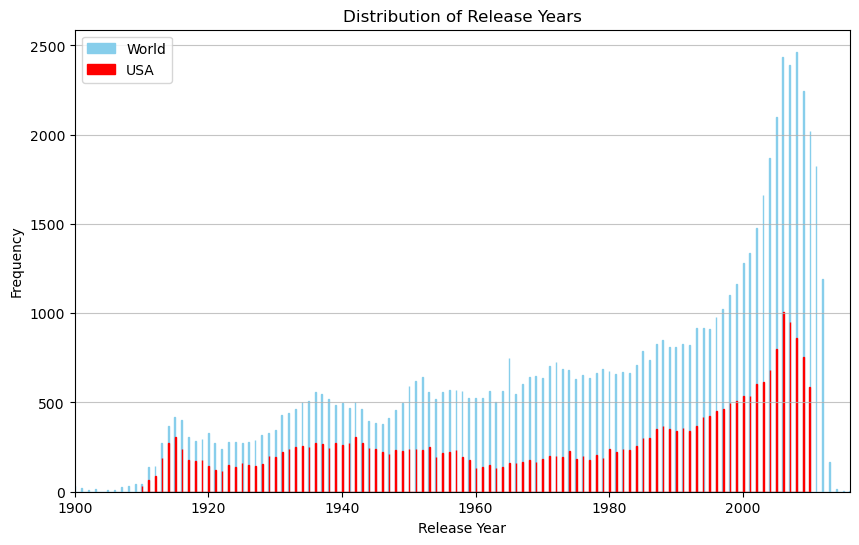

In [24]:
# Looking at distribution of release years

plt.figure(figsize=(10, 6))
plt.hist(movies_all['year'], bins=1000, color='skyblue', edgecolor='skyblue', label='World')
plt.hist(movies['year'], bins=1000, color='red', edgecolor='red', label='USA')
plt.xlabel("Release Year")
plt.xlim(1900, 2016)
plt.ylabel("Frequency")
plt.title("Distribution of Release Years")
plt.grid(axis='y', alpha=0.75)
plt.legend()
plt.show()


It seems that a lot of revenue data is missing. Let's examine the distribution along the years.



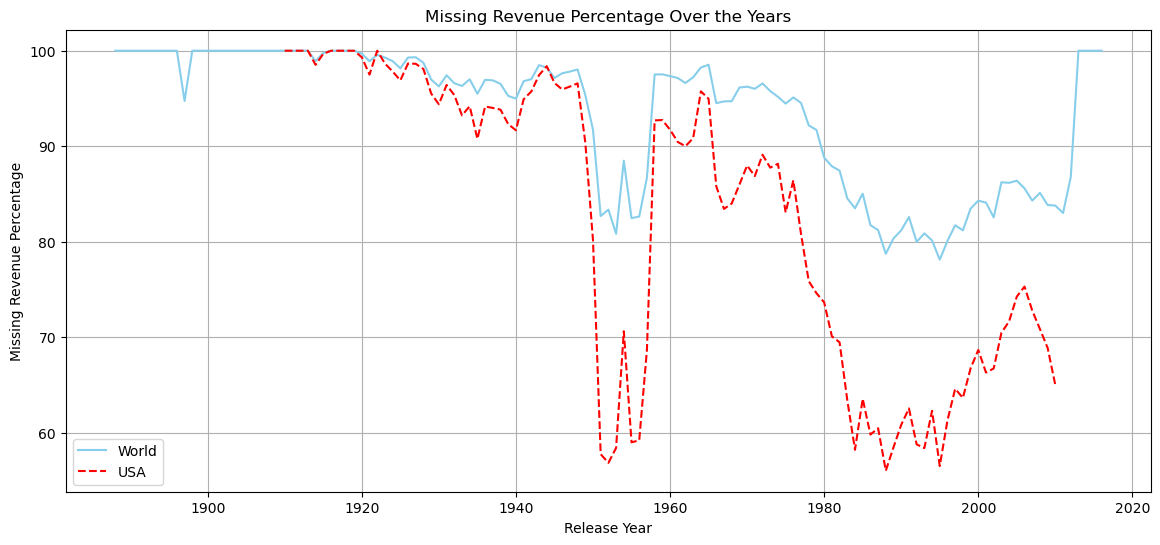

In [25]:
# Let's compare missing revenue data for some countries

missing_revenue_all = calculate_missing_percentage(movies_all, 'year', 'revenue')
missing_revenue_USA = calculate_missing_percentage(movies, 'year', 'revenue')


plt.figure(figsize=(14, 6))

plt.plot(missing_revenue_all.index, missing_revenue_all["revenue"], linestyle='-', color='skyblue', label='World')
plt.plot(missing_revenue_USA.index, missing_revenue_USA["revenue"], linestyle='--', color='r', label='USA')

plt.xlabel("Release Year")
plt.ylabel("Missing Revenue Percentage")
plt.title("Missing Revenue Percentage Over the Years")
plt.grid()
plt.legend()
plt.show()


As seen in the graph above, the missing value percentage for revenue is relatively high across all years (although the USA-only data is cleaner). We will try to address this using additional datasets (cf README).


## 0.3) Enrich the data and cleaning 

As seen in the previous part a lot data is missing for the revenue column. Furthermore, for future analysis of pivotal movies (cf README), we would like to have a review feature. This feature will take value from 0 to 10 and will be linked to another feature : number of reviews available.

In [26]:
MOVIE_STATS = DATA_PATH + 'movie-stats/movies_stats.csv'
MOVIE_LENS = DATA_PATH +'movie_lens/movies_lens.csv'


### i) Loading and cleaning movie-stats

In [27]:
# Loading MovieStats movies df

movies_stats_vanilla = pd.read_csv(MOVIE_STATS)
movies_stats_vanilla.drop(columns=
                          ['genre', 'released', 'director', 'writer',
                           'star', 'company', 'rating', 'budget'], 
                          inplace=True)
movies_stats_vanilla = movies_stats_vanilla.rename(columns={
                                                   'gross': 'revenue',
                                                   'country': 'countries',
                                                   'score': 'review',
                                                   'votes': 'nbr_review'})
display(movies_stats_vanilla.sample(5))
display(movies_stats_vanilla.shape)
display(movies_stats_vanilla.info())
generate_missing_info(movies_stats_vanilla)


,name,year,review,nbr_review,countries,revenue,runtime
7163,A Dog's Purpose,2017,7.2,68000.0,United States,205035819.0,100.0
5864,Friends with Benefits,2011,6.5,348000.0,United States,149542245.0,109.0
7279,Fifty Shades Freed,2018,4.5,59000.0,United States,371987838.0,105.0
2525,Torment,1994,7.1,4500.0,France,39003.0,102.0
6421,Parkland,2013,6.4,15000.0,United States,1412181.0,93.0


(7668, 7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7668 entries, 0 to 7667
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   name        7668 non-null   object 
 1   year        7668 non-null   int64  
 2   review      7665 non-null   float64
 3   nbr_review  7665 non-null   float64
 4   countries   7665 non-null   object 
 5   revenue     7479 non-null   float64
 6   runtime     7664 non-null   float64
dtypes: float64(4), int64(1), object(2)
memory usage: 419.5+ KB


None

,Missing Data (%)
Column,
name,0.00
year,0.00
review,0.04
nbr_review,0.04
countries,0.04
revenue,2.46
runtime,0.05


- Checking release year distribution and country representation

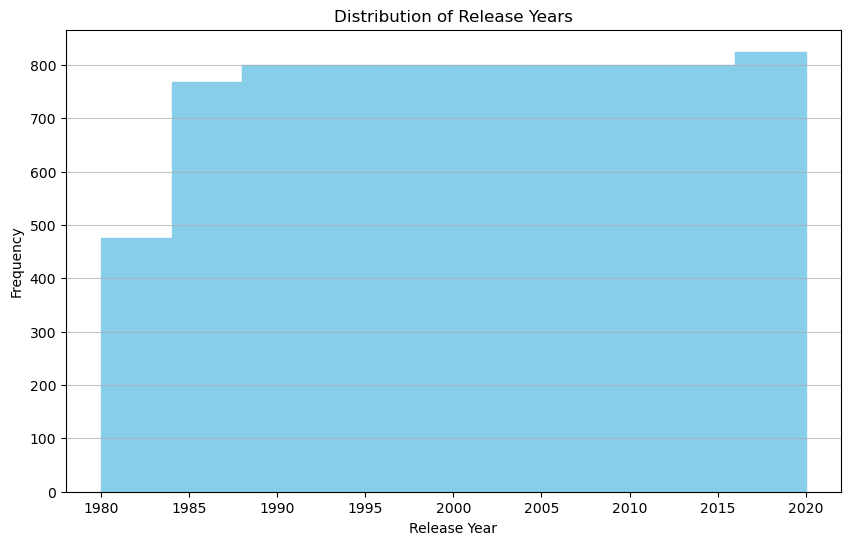

countries
United States     5475
United Kingdom     816
France             279
Canada             190
Germany            117
Australia           92
Japan               81
India               62
Italy               61
Spain               47
Name: count, dtype: int64

In [28]:
plt.figure(figsize=(10, 6))
plt.hist(movies_stats_vanilla['year'], color='skyblue', edgecolor='skyblue')
plt.xlabel("Release Year")
plt.ylabel("Frequency")
plt.title("Distribution of Release Years")
plt.grid(axis='y', alpha=0.75)
plt.show()

display(movies_stats_vanilla['countries'].value_counts().head(10))



- Keep only relevant rows: positive box office and USA only, checking date and runtime.


In [29]:


movies_stats = movies_stats_vanilla.copy(deep=True)

movies_stats = movies_stats.drop(movies_stats.index[movies_stats['year']<1800])
movies_stats.loc[movies_stats['runtime'] < 0, 'runtime'] = 0
movies_stats['runtime'] = movies_stats['runtime'].replace(0, pd.NA)

zero_data = movies_stats[(movies_stats.revenue <= 0)|(movies_stats.revenue.isna())|(movies_stats['countries']!='United States')]
movies_stats.drop(zero_data.index,inplace=True)
display(movies_stats.sample(5))
display(movies_stats.shape)
display(movies_stats.info())
generate_missing_info(movies_stats)


,name,year,review,nbr_review,countries,revenue,runtime
4688,Hitch,2005,6.6,301000.0,United States,371594210.0,118.0
1002,Brighton Beach Memoirs,1986,6.8,3400.0,United States,11957943.0,108.0
1356,Critters 2,1988,5.5,14000.0,United States,3813293.0,86.0
4560,The Forgotten,2004,5.8,65000.0,United States,117592831.0,91.0
6338,Turbo,2013,6.4,88000.0,United States,282570682.0,96.0


(5377, 7)

<class 'pandas.core.frame.DataFrame'>
Index: 5377 entries, 1 to 7659
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   name        5377 non-null   object 
 1   year        5377 non-null   int64  
 2   review      5377 non-null   float64
 3   nbr_review  5377 non-null   float64
 4   countries   5377 non-null   object 
 5   revenue     5377 non-null   float64
 6   runtime     5376 non-null   float64
dtypes: float64(4), int64(1), object(2)
memory usage: 336.1+ KB


None

,Missing Data (%)
Column,
name,0.00
year,0.00
review,0.00
nbr_review,0.00
countries,0.00
revenue,0.00
runtime,0.02


- Check if there are any duplicates

In [30]:
display(check_doublons(movies_stats, ['name'], 'year', 'runtime'))


No duplicates


'--------------------------------------------------------------------------------'

Perfect now the first additional dataset is clean(er) !

### ii) Loading and cleaning movie lens dataset

- Loading Lens movies df

In [31]:
movies_lens_vanilla = pd.read_csv(MOVIE_LENS, usecols=['title', 'release_date', 'production_countries', 'revenue', 'runtime',
                                                      'vote_average', 'vote_count'])
movies_lens_vanilla = movies_lens_vanilla.rename(columns={'production_countries': 'countries',                                                     
                                                         'title': 'name',
                                                         'vote_average': 'review',
                                                         'vote_count': 'nbr_review'})
display(movies_lens_vanilla.sample(5))
display(movies_lens_vanilla.shape)
display(movies_lens_vanilla.info())


,countries,release_date,revenue,runtime,name,review,nbr_review
34488,"[{'iso_3166_1': 'AU', 'name': 'Australia'}]",2015-10-08,0.0,80.0,The Subjects,5.5,22.0
25908,"[{'iso_3166_1': 'IT', 'name': 'Italy'}]",1987-12-19,0.0,110.0,My Sister and I,8.0,2.0
16528,"[{'iso_3166_1': 'US', 'name': 'United States o...",1922-08-28,0.0,17.0,The Frozen North,5.8,11.0
19046,"[{'iso_3166_1': 'US', 'name': 'United States o...",2011-07-19,0.0,90.0,House of the Rising Sun,4.2,19.0
32375,"[{'iso_3166_1': 'BG', 'name': 'Bulgaria'}, {'i...",2012-08-08,0.0,90.0,Dungeons & Dragons: The Book of Vile Darkness,4.2,17.0


(45466, 7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   countries     45463 non-null  object 
 1   release_date  45379 non-null  object 
 2   revenue       45460 non-null  float64
 3   runtime       45203 non-null  float64
 4   name          45460 non-null  object 
 5   review        45460 non-null  float64
 6   nbr_review    45460 non-null  float64
dtypes: float64(4), object(3)
memory usage: 2.4+ MB


None

- Keep only relevant columns, check budget and runtime

In [32]:
movies_lens = movies_lens_vanilla.copy(deep=True)
zero_data = movies_lens[(movies_lens.revenue <= 0)|(movies_lens.revenue.isna()|movies_lens.release_date.isna())]
movies_lens.drop(zero_data.index,inplace=True)
movies_lens.reset_index(drop=True, inplace=True)

movies_lens.loc[:, 'year'] = movies_lens['release_date'].str.split('-', expand=True)[0]
movies_lens.loc[:, 'year'] = movies_lens['year'].astype(int)
movies_lens = movies_lens.drop(columns='release_date')


movies_lens.loc[movies_lens['runtime'] < 0, 'runtime'] = 0
movies_lens['runtime'] = movies_lens['runtime'].replace(0, pd.NA)

movies_lens['year'] = movies_lens['year'].astype(int)
movies_lens['runtime'] = pd.to_numeric(movies_lens['runtime'], errors='coerce')



display(movies_lens.sample(5))
display(movies_lens.shape)
display(movies_lens.info())



,countries,revenue,runtime,name,review,nbr_review,year
130,"[{'iso_3166_1': 'MX', 'name': 'Mexico'}]",21665468.0,105.0,Like Water for Chocolate,6.6,70.0,1992
573,"[{'iso_3166_1': 'IN', 'name': 'India'}, {'iso_...",77737889.0,191.0,Gandhi,7.4,730.0,1982
1338,"[{'iso_3166_1': 'US', 'name': 'United States o...",5344577.0,113.0,Monkey Shines,6.2,58.0,1988
6704,"[{'iso_3166_1': 'ZA', 'name': 'South Africa'},...",133332.0,96.0,Momentum,5.9,168.0,2015
3878,"[{'iso_3166_1': 'US', 'name': 'United States o...",5914908.0,108.0,The Good German,5.9,87.0,2006


(7407, 7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7407 entries, 0 to 7406
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   countries   7407 non-null   object 
 1   revenue     7407 non-null   float64
 2   runtime     7380 non-null   float64
 3   name        7407 non-null   object 
 4   review      7407 non-null   float64
 5   nbr_review  7407 non-null   float64
 6   year        7407 non-null   int32  
dtypes: float64(4), int32(1), object(2)
memory usage: 376.3+ KB


None

In [33]:
# Handling format
movies_lens['countries'] = movies_lens['countries'].apply(lambda x: [country['name'] for country in ast.literal_eval(x)] if pd.notna(x) else [])

# Handle multi-countries movies to keep only one country per movie (prioritize USA above others)
movies_lens = separate_values_biased(movies_lens, 'countries', 'United States of America')

display(movies_lens.sample(5))
display(movies_lens.shape)
display(movies_lens.info())


,countries,revenue,runtime,name,review,nbr_review,year
5655,United Kingdom,641.0,99.0,Hammer of the Gods,4.4,95.0,2013
7019,Brazil,1672940.0,104.0,Till Luck Do Us Part,6.4,51.0,2012
2338,United States of America,1008404.0,85.0,Whore,5.6,18.0,1991
1934,United States of America,4905000.0,128.0,The Magnificent Seven,7.4,472.0,1960
1559,United States of America,2500000.0,107.0,Double Indemnity,8.0,425.0,1944


(7407, 7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7407 entries, 0 to 7406
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   countries   7255 non-null   object 
 1   revenue     7407 non-null   float64
 2   runtime     7380 non-null   float64
 3   name        7407 non-null   object 
 4   review      7407 non-null   float64
 5   nbr_review  7407 non-null   float64
 6   year        7407 non-null   int32  
dtypes: float64(4), int32(1), object(2)
memory usage: 376.3+ KB


None

- Keep only the USA

In [34]:
movies_lens = movies_lens[movies_lens['countries']=='United States of America'].drop(
columns='countries')

display(movies_lens.sample(5))
display(movies_lens.shape)
display(movies_lens.info())



,revenue,runtime,name,review,nbr_review,year
4604,709827462.0,130.0,The Twilight Saga: New Moon,5.6,2518.0,2009
292,463000000.0,119.0,Pretty Woman,7.0,1807.0,1990
3203,367275019.0,90.0,Shark Tale,5.8,1612.0,2004
4410,12764201.0,97.0,Street Fighter: The Legend of Chun-Li,3.9,113.0,2009
2247,11129057.0,102.0,Falling in Love,6.4,61.0,1984


(5623, 6)

<class 'pandas.core.frame.DataFrame'>
Index: 5623 entries, 0 to 7396
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   revenue     5623 non-null   float64
 1   runtime     5623 non-null   float64
 2   name        5623 non-null   object 
 3   review      5623 non-null   float64
 4   nbr_review  5623 non-null   float64
 5   year        5623 non-null   int32  
dtypes: float64(4), int32(1), object(1)
memory usage: 285.5+ KB


None

- Check if there are any duplicates

In [35]:
display(check_doublons(movies_lens, ['name'], 'year', 'runtime'))


Rows with real duplicates: 
                                             name  year  runtime
415                            A Farewell to Arms  1932     89.0
2301                                Clockstoppers  2002     94.0
2444  Pokémon 4Ever: Celebi - Voice of the Forest  2001     75.0
2548              Confessions of a Dangerous Mind  2002    113.0
4721                           A Farewell to Arms  1932     89.0
6692                                Clockstoppers  2002     94.0
6695              Confessions of a Dangerous Mind  2002    113.0
7381  Pokémon 4Ever: Celebi - Voice of the Forest  2001     75.0


'--------------------------------------------------------------------------------'

In [36]:
movies_lens = fuse_duplicates(movies_lens, col_check=['name'], year='year', runtime='runtime',
                         col_len=[], col_null=['revenue', 'review', 'nbr_review'])
check_doublons(movies_lens, ['name'], 'year', 'runtime')


Fusing duplicates: 
Duplicates fused successfully.
--------------------------------------------------------------------------------
No duplicates


'--------------------------------------------------------------------------------'

- Check release year distribution

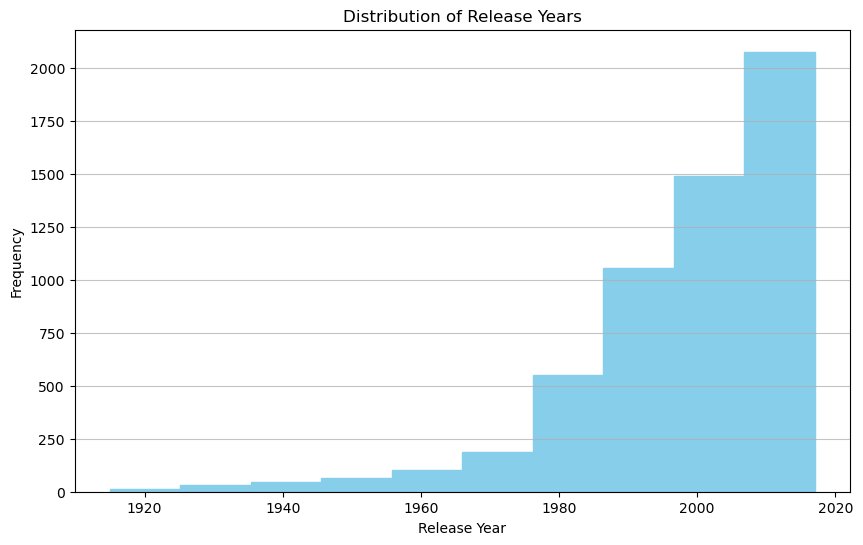

In [37]:
plt.figure(figsize=(10, 6))
plt.hist(movies_lens['year'], color='skyblue', edgecolor='skyblue')
plt.xlabel("Release Year")
plt.ylabel("Frequency")
plt.title("Distribution of Release Years")
plt.grid(axis='y', alpha=0.75)
plt.show()


### iii) Merging the two extra dataframes

Now that the two extra datasets are clean, let's merge them into the annex dataframe.

In [38]:
annex = pd.merge(movies_stats, movies_lens, how='outer', on=['name', 'year', 'runtime'])

display(annex.sample(5))
display(annex.shape)
display(annex.info())


,name,year,review_x,nbr_review_x,countries,revenue_x,runtime,revenue_y,review_y,nbr_review_y
2302,Affliction,1997,7.0,16000.0,United States,6330054.0,114.0,6330054.0,5.8,56.0
3895,Star Trek,2009,7.9,585000.0,United States,385680446.0,127.0,385680446.0,7.4,4574.0
4115,Skyline,2010,4.4,88000.0,United States,66984887.0,92.0,NaN,NaN,NaN
4931,Bridget Jones's Baby,2016,6.5,71000.0,United States,211952420.0,123.0,211952420.0,6.3,972.0
2581,Holy Smoke,1999,5.9,14000.0,United States,1765545.0,115.0,NaN,NaN,NaN


(8136, 10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8136 entries, 0 to 8135
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          8136 non-null   object 
 1   year          8136 non-null   int64  
 2   review_x      5377 non-null   float64
 3   nbr_review_x  5377 non-null   float64
 4   countries     5377 non-null   object 
 5   revenue_x     5377 non-null   float64
 6   runtime       8135 non-null   float64
 7   revenue_y     5619 non-null   float64
 8   review_y      5619 non-null   float64
 9   nbr_review_y  5619 non-null   float64
dtypes: float64(7), int64(1), object(2)
memory usage: 635.8+ KB


None

- Let's merge the revenues columns

In [39]:
annex['revenue'] = annex.apply(lambda row: fuse_columns(row[f'revenue_x'], row[f'revenue_y'], 'revenue'), axis=1)

annex = annex.drop(columns=['revenue_x', 'revenue_y', 'countries'])
display(annex.sample(5))
display(annex.shape)
display(annex.info())


,name,year,review_x,nbr_review_x,runtime,review_y,nbr_review_y,revenue
3413,The Greatest Game Ever Played,2005,7.4,29000.0,120.0,6.9,112.0,15431177.0
1598,Dazed and Confused,1993,7.6,171000.0,102.0,7.4,588.0,7993039.0
6697,Mannequin Two: On the Move,1991,NaN,NaN,95.0,4.6,28.0,3752426.0
2199,Mr. Wrong,1996,3.8,4800.0,96.0,NaN,NaN,12825141.0
587,The Karate Kid Part II,1986,6.1,82000.0,113.0,NaN,NaN,115103979.0


(8136, 8)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8136 entries, 0 to 8135
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          8136 non-null   object 
 1   year          8136 non-null   int64  
 2   review_x      5377 non-null   float64
 3   nbr_review_x  5377 non-null   float64
 4   runtime       8135 non-null   float64
 5   review_y      5619 non-null   float64
 6   nbr_review_y  5619 non-null   float64
 7   revenue       8136 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 508.6+ KB


None

- Let's merge the reviews columns.

In [40]:
annex = fuse_scores(annex, 'review_x', 'review_y', 'nbr_review_x', 'nbr_review_y')
display(annex.sample(5))
display(annex.shape)
display(annex.info())
display(annex[annex['review']<=0])
display(annex[annex['nbr_review']<=0])


,name,year,runtime,revenue,review,nbr_review
3448,Beauty Shop,2005,105.0,3.679840e+07,5.598621,17118.0
6551,Good Guys Wear Black,1978,95.0,1.830000e+07,5.700000,19.0
3887,Shorts,2008,89.0,2.897251e+07,4.700000,7000.0
4481,Frozen,2013,102.0,1.277864e+09,7.399079,590440.0
5266,Knives Out,2019,130.0,3.115394e+08,7.900000,505000.0


(8136, 6)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8136 entries, 0 to 8135
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   name        8136 non-null   object 
 1   year        8136 non-null   int64  
 2   runtime     8135 non-null   float64
 3   revenue     8136 non-null   float64
 4   review      8122 non-null   float64
 5   nbr_review  8122 non-null   float64
dtypes: float64(4), int64(1), object(1)
memory usage: 381.5+ KB


None

,name,year,runtime,revenue,review,nbr_review


,name,year,runtime,revenue,review,nbr_review


- Check if there are any duplicates.

In [41]:
check_doublons(annex, ['name'], 'year', 'runtime')


No duplicates


'--------------------------------------------------------------------------------'

In [42]:
display(annex.info())
display(movies.info())
movies['runtime'] = pd.to_numeric(movies['runtime'], errors='coerce')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8136 entries, 0 to 8135
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   name        8136 non-null   object 
 1   year        8136 non-null   int64  
 2   runtime     8135 non-null   float64
 3   revenue     8136 non-null   float64
 4   review      8122 non-null   float64
 5   nbr_review  8122 non-null   float64
dtypes: float64(4), int64(1), object(1)
memory usage: 381.5+ KB


None

<class 'pandas.core.frame.DataFrame'>
Index: 28821 entries, 0 to 74827
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id_wiki      28821 non-null  int64  
 1   id_freebase  28821 non-null  object 
 2   name         28821 non-null  object 
 3   year         28821 non-null  int32  
 4   revenue      6466 non-null   float64
 5   runtime      25712 non-null  object 
 6   lang         28821 non-null  object 
 7   countries    28821 non-null  object 
 8   genres       28821 non-null  object 
dtypes: float64(1), int32(1), int64(1), object(6)
memory usage: 2.1+ MB


None

Now that annex is properly merged let's do the final merge with movies dataframe

In [43]:
movies2 = pd.merge(movies, annex, on=['name', 'year', 'runtime'], how='left')
display(movies2.sample(5))
display(movies2.shape)
display(movies2.info())


,id_wiki,id_freebase,name,year,revenue_x,runtime,lang,countries,genres,revenue_y,review,nbr_review
7548,7305989,/m/0kv4nn,Abominable,2006,NaN,94.0,[English Language],[USA],"[Thriller, Horror]",NaN,NaN,NaN
14076,28066419,/m/0cmdkjl,One Year Later,1933,NaN,69.0,[English Language],[USA],[Drama],NaN,NaN,NaN
8479,9246760,/m/0281hts,Everything Will Be OK,2006,NaN,17.0,[English Language],[USA],"[Short Film, Animation]",NaN,NaN,NaN
9043,16839658,/m/0407yq4,Youth Runs Wild,1944,NaN,67.0,[English Language],[USA],"[Drama, Black-and-white]",NaN,NaN,NaN
27367,4343413,/m/0by51q,Pulse,1988,NaN,86.0,[English Language],[USA],"[Thriller, Science Fiction, Horror, Supernatural]",NaN,NaN,NaN


(28821, 12)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28821 entries, 0 to 28820
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id_wiki      28821 non-null  int64  
 1   id_freebase  28821 non-null  object 
 2   name         28821 non-null  object 
 3   year         28821 non-null  int32  
 4   revenue_x    6466 non-null   float64
 5   runtime      25712 non-null  float64
 6   lang         28821 non-null  object 
 7   countries    28821 non-null  object 
 8   genres       28821 non-null  object 
 9   revenue_y    2716 non-null   float64
 10  review       2714 non-null   float64
 11  nbr_review   2714 non-null   float64
dtypes: float64(5), int32(1), int64(1), object(5)
memory usage: 2.5+ MB


None

- Fusing the box office data

In [44]:
movies2['revenue'] = movies2.apply(lambda row: fuse_columns(row[f'revenue_x'], row[f'revenue_y'], 'revenue'), axis=1)

movies2 = movies2.drop(columns=['revenue_x', 'revenue_y'])

display(movies2.sample(5))
display(movies2.shape)
display(movies2.info())



,id_wiki,id_freebase,name,year,runtime,lang,countries,genres,review,nbr_review,revenue
968,3984733,/m/0bb1gt,Bopha!,1993,121.0,[English Language],[USA],"[Drama, Political drama]",NaN,NaN,<NA>
16660,12917337,/m/02y_h1m,Time Out for Rhythm,1941,75.0,[English Language],[USA],"[Musical, Comedy, Slapstick]",NaN,NaN,<NA>
3604,3575300,/m/09mksc,Punishment Park,1971,88.0,[English Language],[USA],"[Thriller, Psychological thriller, Drama, War ...",NaN,NaN,<NA>
16001,980977,/m/03wcm1,The Secret of My Success,1987,110.0,[English Language],[USA],"[Romantic comedy, Romance Film, Comedy]",NaN,NaN,110996879.0
21222,7385632,/m/0kv6g3,The Shriner's Daughter,1913,NaN,"[Silent film, English Language]",[USA],"[Short Film, Silent film, Indie, Black-and-white]",NaN,NaN,<NA>


(28821, 11)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28821 entries, 0 to 28820
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id_wiki      28821 non-null  int64  
 1   id_freebase  28821 non-null  object 
 2   name         28821 non-null  object 
 3   year         28821 non-null  int32  
 4   runtime      25712 non-null  float64
 5   lang         28821 non-null  object 
 6   countries    28821 non-null  object 
 7   genres       28821 non-null  object 
 8   review       2714 non-null   float64
 9   nbr_review   2714 non-null   float64
 10  revenue      6946 non-null   object 
dtypes: float64(3), int32(1), int64(1), object(6)
memory usage: 2.3+ MB


None

- Vizualize improvements on missing revenue data post-merge

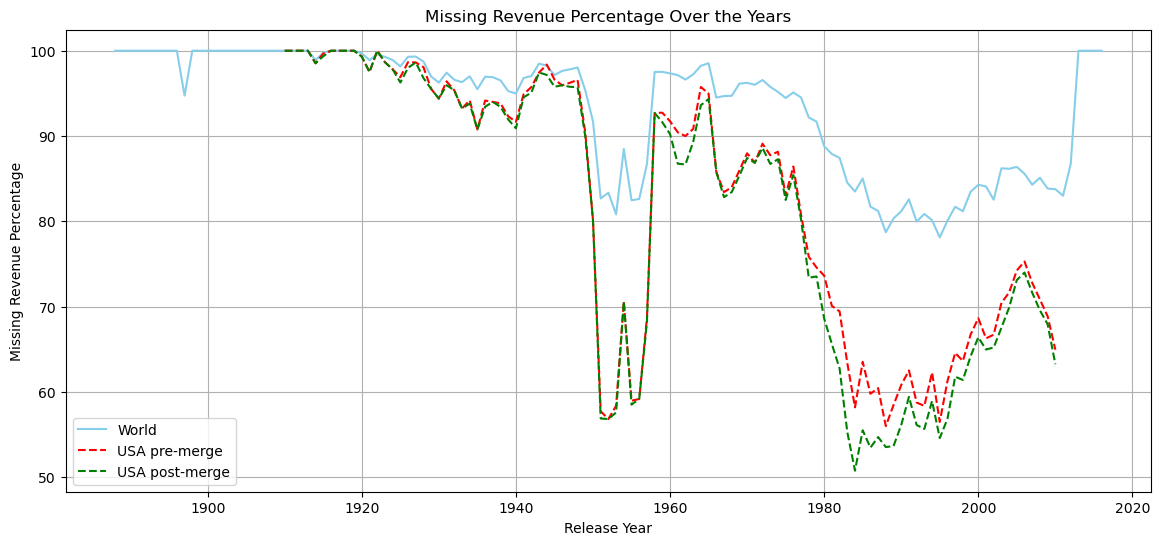

In [45]:
missing_revenue_USA_merge = calculate_missing_percentage(movies2, 'year', 'revenue')

plt.figure(figsize=(14, 6))
plt.plot(missing_revenue_all.index, missing_revenue_all["revenue"], linestyle='-', color='skyblue', label='World')
plt.plot(missing_revenue_USA.index, missing_revenue_USA["revenue"], linestyle='--', color='r', label='USA pre-merge')
plt.plot(missing_revenue_USA_merge.index, missing_revenue_USA_merge["revenue"], linestyle='--', color='g', label='USA post-merge')
plt.xlabel("Release Year")
plt.ylabel("Missing Revenue Percentage")
plt.title("Missing Revenue Percentage Over the Years")
plt.grid()
plt.legend()
plt.show()


It looks better, less data is missing for the revenue !


- Create a dataframe with no missing box office data

In [46]:
movies2_clean = movies2.copy(deep=True)
movies2_clean = movies2.dropna(subset=['revenue']).reset_index(drop=True)

display(movies2_clean.sample(5))
display(movies2_clean.shape)
display(movies2_clean.info())


,id_wiki,id_freebase,name,year,runtime,lang,countries,genres,review,nbr_review,revenue
1860,21206525,/m/05c47gr,Weather Girl,2009,92.0,[English Language],[USA],[Comedy film],NaN,NaN,22779.0
3059,1068520,/m/0435vm,The Island,2005,138.0,[English Language],[USA],"[Thriller, Science Fiction, Action/Adventure, ...",NaN,NaN,162949164.0
3777,745100,/m/037s6_,James and the Giant Peach,1996,76.0,[English Language],"[USA, United Kingdom]","[Adventure, Children's/Family, Stop motion, An...",NaN,NaN,37734758.0
2972,167599,/m/016dj8,Men in Black,1997,97.0,"[English Language, Spanish Language]",[USA],"[Action/Adventure, Science Fiction, Action, Bu...",NaN,NaN,589390539.0
1538,2997971,/m/08jml6,Drumline,2002,119.0,[English Language],[USA],"[Romantic comedy, Comedy-drama, Coming of age,...",NaN,NaN,57588485.0


(6946, 11)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6946 entries, 0 to 6945
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id_wiki      6946 non-null   int64  
 1   id_freebase  6946 non-null   object 
 2   name         6946 non-null   object 
 3   year         6946 non-null   int32  
 4   runtime      6937 non-null   float64
 5   lang         6946 non-null   object 
 6   countries    6946 non-null   object 
 7   genres       6946 non-null   object 
 8   review       2714 non-null   float64
 9   nbr_review   2714 non-null   float64
 10  revenue      6946 non-null   object 
dtypes: float64(3), int32(1), int64(1), object(6)
memory usage: 569.9+ KB


None

In [47]:
movies2_clean['revenue_part'] = movies2_clean.groupby('year')['revenue'].transform(lambda x: x / x.sum())
 

display(movies2_clean.sample(5))
display(movies2_clean.shape)
display(movies2_clean.info())


,id_wiki,id_freebase,name,year,runtime,lang,countries,genres,review,nbr_review,revenue,revenue_part
4840,3923568,/m/0b6_ds,Painting the Clouds with Sunshine,1951,87.0,[English Language],[USA],[Musical],NaN,NaN,1800000.0,0.002249
524,1384107,/m/04y8pc,Jeepers Creepers II,2003,104.0,[English Language],[USA],"[Monster movie, Cult, Horror, Teen]",NaN,NaN,63102666.0,0.003641
5716,146077,/m/025rvx0,Empire of the Sun,1987,152.0,"[Japanese Language, Standard Mandarin, English...",[USA],"[Biography, Film adaptation, Childhood Drama, ...",NaN,NaN,66240000.0,0.016058
164,275547,/m/01p8m2,Selena,1997,128.0,[English Language],[USA],"[Biographical film, Biography, Drama, Musical ...",NaN,NaN,35450113.0,0.002937
1617,1055466,/m/0422v0,Primal Fear,1996,129.0,[English Language],[USA],"[Thriller, Mystery, Crime Fiction, Drama]",7.699018,196644.0,102616183.0,0.010662


(6946, 12)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6946 entries, 0 to 6945
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id_wiki       6946 non-null   int64  
 1   id_freebase   6946 non-null   object 
 2   name          6946 non-null   object 
 3   year          6946 non-null   int32  
 4   runtime       6937 non-null   float64
 5   lang          6946 non-null   object 
 6   countries     6946 non-null   object 
 7   genres        6946 non-null   object 
 8   review        2714 non-null   float64
 9   nbr_review    2714 non-null   float64
 10  revenue       6946 non-null   object 
 11  revenue_part  6946 non-null   object 
dtypes: float64(3), int32(1), int64(1), object(7)
memory usage: 624.2+ KB


None

## 0.4) Playing with the data before serious business (first approaches)

In this section, we will provide an example of how we could identify pivotal movies using a relatively simple approach. This part aims to offer insights into the process of recognizing pivotal movies within a dataset.

### i) Analysing a trend: first approach

To effectively identify the 'hype generator,' it's essential to define 'hype' precisely. We have opted to measure hype as the annual percentage change in the production of various movie genres. This approach accounts for the evolving ease of movie production and the resultant increase in the overall number of films produced each year. By focusing on yearly percentage changes, we can effectively neutralize the impact of the growing volume of movie production, ensuring our analysis remains robust and accurate.


Size subset (Teen) 28821


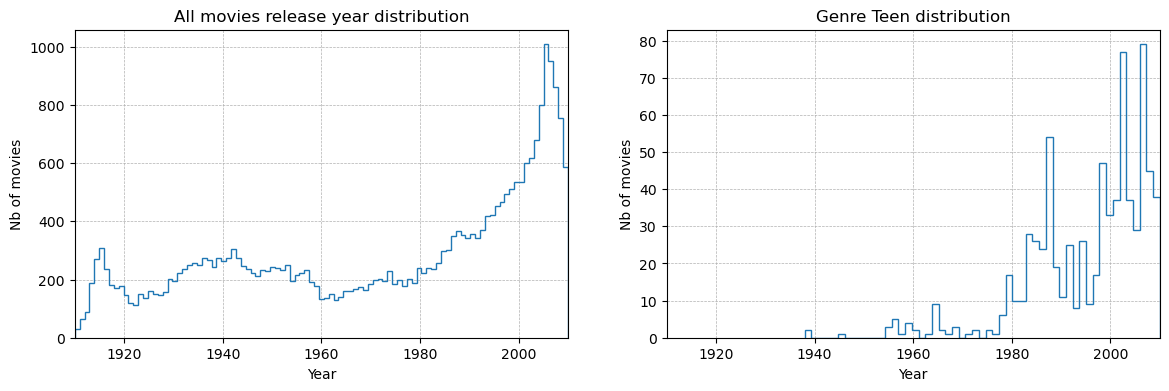

In [48]:
# Create a subset to compare to the whole dataset (here: Teen Movies)
key = 'Teen'
subset = create_subset(movies2, key)
print("Size subset ({}) {}".format(key, len(movies2)))

# Plot release dates distribution
fig, axs = plt.subplots(1, 2, figsize=(14,4))
axs = axs.ravel()

movies.year.hist(bins=movies2.year.nunique(), ax=axs[0], histtype='step')
ax_settings(axs[0], xlabel='Year', ylabel='Nb of movies', title='All movies release year distribution')
axs[0].set_xlim((1910,2010))

subset.year.hist(bins=subset.year.nunique(), ax=axs[1], histtype='step')
ax_settings(axs[1], xlabel='Year', ylabel='Nb of movies', title='Genre {} distribution'.format(key))
axs[1].set_xlim((1910,2010))

plt.show()

This is an early version of the analysis. Here we simply plot the number of movies distribution, but we plan to use the fraction of (subset) movies distribution later for more robust results. However, this already gives us an idea of what we could expect from the data.

We display two graphs above. The left plot is the distribution of movie releases over time. The right plot shows the evolution of number of movies releases over time, of the genre "Teen movie". We immediately notice several elements. First the shapes of the two curves are markedly different, this confirms us that we choose an interesting subset for analysis, since it differs from the baseline. Now by looking more closely, we see that the genre Teen emerged at a certain point in cinema, because (almost) no data exists before late 70's, and we have no record before late 50's. This is very indicating about the existence of a trend ! But we can extract more, we significantly see two bumps in the Teen plot centered around two different decades. Without going much further here, we can already assume that pivotal movies are hiding here...

### ii) Evolution of genre between 1990 and 2012

After this initial example, let's delve deeper into the evolution of 15 genres (ranked in popularity for the considered time range, from 15th place to 30th place) across 30 years of cinema. In this analysis, we shift our focus from the raw number of films released to the percentage relative to the total number of films released each year. This perspective provides a more nuanced understanding of the genre distribution over the years.


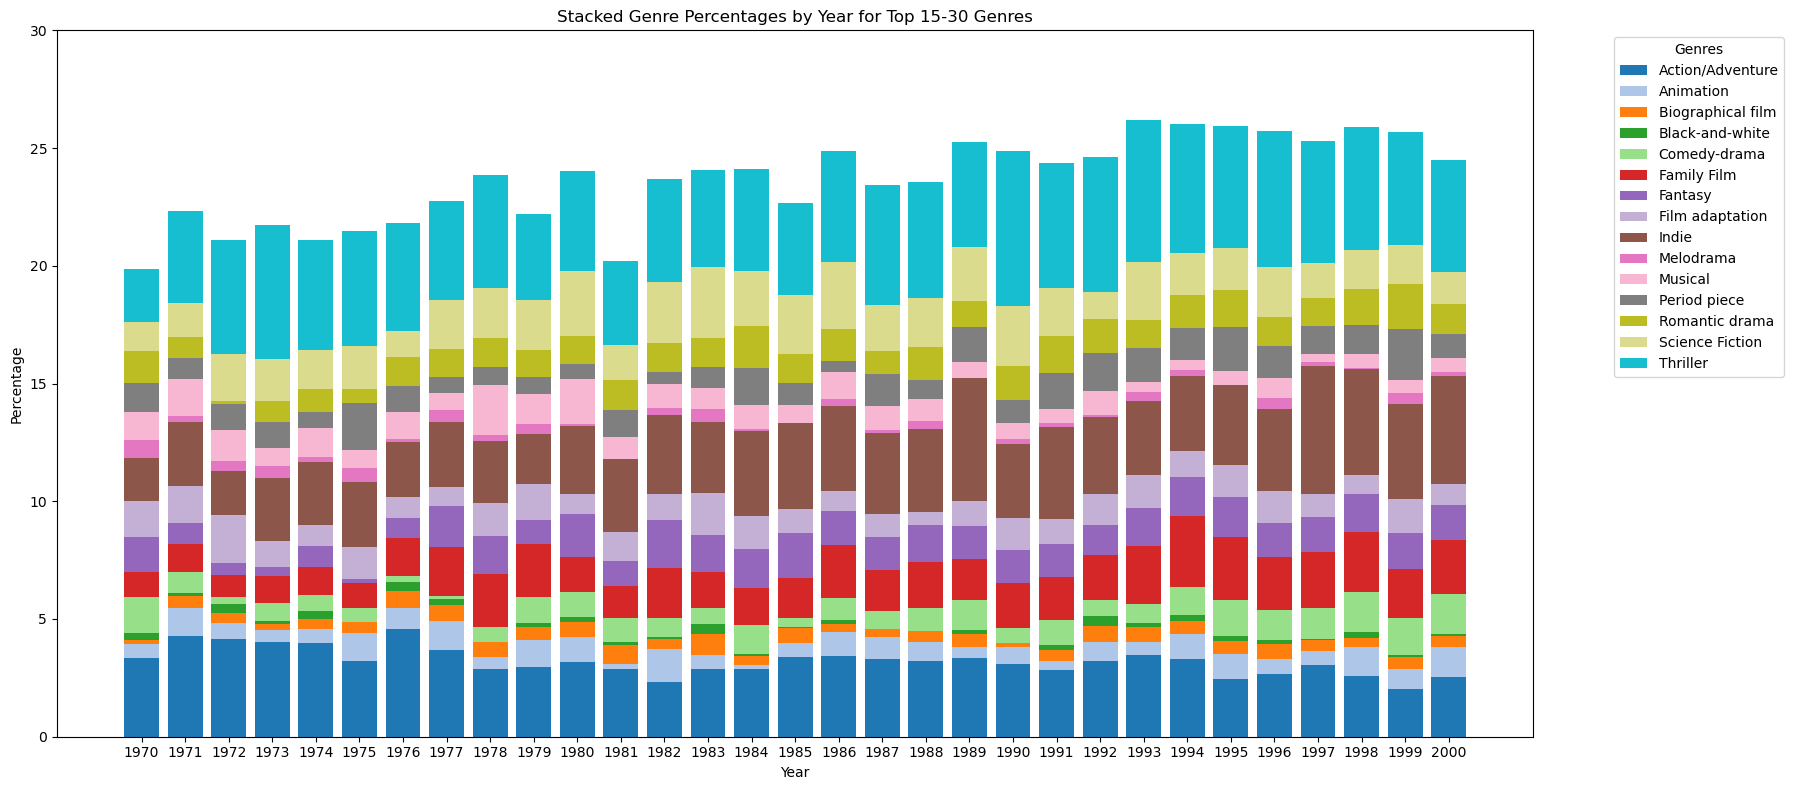

In [49]:
plot_genres_percentages_per_year(movies2, 1970, 2000, 15,30,30)

From the graph above we can for example identify two big varitions in genres 'Biography' in range 1990-1996 and 'Comedy-drama' in range 1978-1983.

We will next focus on identifying the movie that ignited this surge in popularity. By examining films in the pertinent genres and identifying the highest-grossing one in the 5 year prior (based on the assumption that it takes 5 years to produce a movie), we aim to pinpoint the film that was instrumental in boosting the genre's appeal.

- Biography potential hype generator 


In [50]:
biography_film_movies = movies2[movies2['genres'].apply(lambda x: "Biography" in x)] # look for genre: biography film

biography_films_1990_2000 = biography_film_movies[(biography_film_movies['year'] >= 1986)
                                    & (biography_film_movies['year'] <= 1991)]

highest_revenue_movie = biography_films_1990_2000[biography_films_1990_2000['revenue'].notna()].sort_values('revenue', ascending=False).head(4)

display(highest_revenue_movie[["name","year","revenue"]])

,name,year,revenue
22452,JFK,1991,205400000.0
17147,Born on the Fourth of July,1989,196672350.0
26823,The Untouchables,1987,76270454.0
23752,Empire of the Sun,1987,66240000.0


- Comedy drama potential hype generator 


In [51]:
comedy_drama_film_movies = movies2[movies2['genres'].apply(lambda x: "Comedy-drama" in x)] # look for genre: comedy_drama film

comedy_drama_films_1990_2000 = comedy_drama_film_movies[(comedy_drama_film_movies['year'] >= 1973) & (comedy_drama_film_movies['year'] <= 1978)]

highest_revenue_movie = comedy_drama_films_1990_2000[comedy_drama_films_1990_2000['revenue'].notna()].sort_values('revenue', ascending=False).head(4)

display(highest_revenue_movie[["name","year","revenue"]])

,name,year,revenue
2299,American Graffiti,1973,140000000.0
16623,One Flew Over the Cuckoo's Nest,1975,108981275.0
5613,Shampoo,1975,60000000.0
24068,Semi-Tough,1977,37187139.0


In this approach, we identified potential hype generators by looking at films of the same genre that have been released before the trend and generated significant revenues. If we look only at the most revenue generated, the two pivotal movies would be 'JFK' for Biography and 'American Graffiti' for Comedy-drama. However, we see that other movies have a similar order of magnitude of revenue, which hints at the potential limit of this naive approach.


### iii) Identification of the trend by looking at the percentage change
Now we want to automate the process recently done with the art movie in order to predict the hype generators:


We will now identify the genre that experienced the highest percentage change in popularity between 1990 and 2013. A significant change in this percentage is indicative of a 'hype' in the genre, revealing shifts in audience and producers preferences and trends during this period.

We now shift our focus to identifying movies that sparked a surge in popularity. Our approach involves examining films within relevant genres and determining the highest-grossing one in the 5 years prior (considering the assumption that movie production takes 5 years, as stated in the README). The chosen genre for popularity is crucial, as it can impact our analysis. Top genres are often too broad and mainstream, while those at the bottom tend to be too specialized and niche. By selecting this middle range, we aim to strike a balance, capturing genres that are neither overly generic nor excessively niche. In the following case we only take the top 15 to top 30 most 

In [52]:
hype_generators(movies,1990,2013,15,30)

Highest change in percentage by genre between 1990 and  2013 (hype))
 index  year             genres  count  percentage  percentage_change
  8044  1994        Documentary     31    1.726058           0.718506
 10499  2007    Domestic Comedy      7    0.172712           2.575993
 11089  2010              Drama    254   11.179577           0.236074
 11091  2010      Ensemble Film      7    0.308099           2.213468
  8243  1995         Gay Themed      8    0.407332           6.315682
  9112  2000      Gender Issues      4    0.162140           2.794082
  9937  2004            Musical     35    1.157407           0.854424
  9940  2004            Mystery     45    1.488095           0.479885
  7937  1993             Parody     14    0.878845           0.609385
  8278  1995    Political drama     12    0.610998           2.657841
  8447  1996 Political thriller      4    0.206292           3.051573
  8451  1996         Road movie      8    0.412584           1.701049
  9964  2004         

This assessment leads to interesting results such as 'Fantasy' associated with *'The Lord of the Rings: The Return of the King'* or 'Science Fiction' and *'Back to the Future'*. However, some results are rising questions on this naive method. For instance, 'Romance Film' associated to *Star Wars Episode II: Attack of the Clones* demonstrates the limit of the actual naive method. In the future we aim to identify more clearly the principal genre of the movie.

<p align="center">
  <img src="images/StarWars.png" width=50%>

# 1) Finding trends

In this section, we will first analyze trends in specific genres of movies. The aim is to exctract potential candidates for pivotal movies. Indeed, let's remind that a pivotal movie is a movie that produced a trend that's why in this fisrt part we are focusing on trend.

## 1.1) Selection of subsets by genre

Let's extract the data to analyze. We want two lists: one with movies for each single genres, one with movies for each double genres.

In [53]:
subsets = select_subsets(movies, min_len=10)
print('Number of subsets: {}'.format(len(subsets)))
print('Format: list of ("genre_name", DF)')

Number of subsets: 244
Format: list of ("genre_name", DF)


In [54]:
subsets_double = select_subsets_double(subsets, min_len=100)
print('Number of subsets double: {}'.format(len(subsets_double)))
print('Format: list of (("genre1_name","genre2_name"), DF)')

Number of subsets double: 424
Format: list of (("genre1_name","genre2_name"), DF)


## 1.2) Trend graphs for some genres


Now, let's visualize one subset. The <u>first plot</u> shows the number of releases for all movies, each year. The <u>second</u> is the same but for a perticular subset of a (single) genre. We can already compare the graphs and get an idea of the trend in this genre. But this is still not enough, because as we can see the total number of movies grows drastically over years ! Then to lead a more rigorous analysis, we're interested in a more suitable format. The <u>last plot</u> computes for each year the fraction of movie releases in the genre, within the total movie releases of the year. This format is less sensitive to the exploding numbers of movies in the early 2000's, and more representative of the popularity of a genre in the market. We will use it for further analysis.

You can try to change the value of *i* and switch between visualizations of subsets.

Subset: Film noir
	518 | 28821 (size subset | movies)
	= 1.7973 %


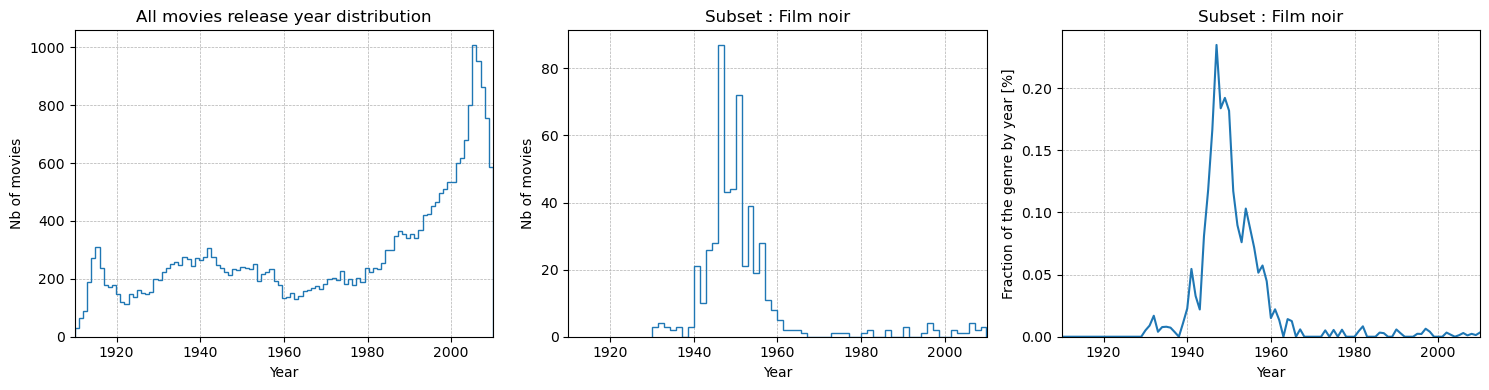

In [55]:
# VISUALIZE SUBSET i
i = find_subset(subsets, 'Film noir')
viz_subset(i, subsets, movies)

We can do the same analysis for subsets of double genres. Note that all combination of genres are not necessarily relevant, so it is up to the discussion for interesting combinations.

Subset: ('Action', 'Adventure')
	1150 | 28821 (size subset | movies)
	= 3.9901 %


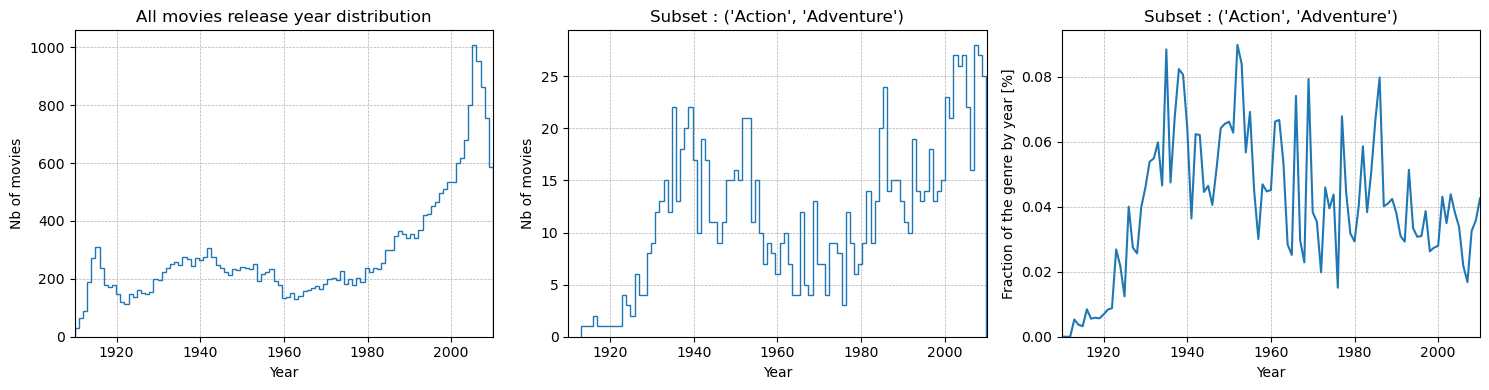

In [56]:
# VISUALIZE SUBSET DOUBLE i
i = find_subset_double(subsets_double, 'Adventure', 'Action')
viz_subset(i, subsets_double, movies)

## 1.3) Trend automatic detection

We are ready for large scale trend detection. For each subset we will perform signal processing of the fraction distribution to extract insights from them. Especially we are interested in the peak, the inflexion and the quality of the peak.

Our signal processing method applies a Butterworth lowpass filter on the fraction distribution, which looks very "noisy" at a first glance. Thus it gives in result the smoothed version of the distribution, easier to analyze.

From the smoothed signal, we can easily get the peaks of the trends, ie. max local. Then we are interested in the inflexion point before each peak, because they represent the steepest slope before the trend. We might assume that a pivotal movie responsible for a trend should hide around. Finally, we would like to assess the quality of a peak, to differentiate the important trends from the small bumps of the graph. We represent that value by the difference of height of the peak and the inflexion, and we take the ratio of this difference with the historic fraction of the genre (over all years).

In [57]:
QUALITY = 0.2
trends = get_trends(movies, subsets, QUALITY)
trends_double = get_trends(movies, subsets_double, QUALITY)

print('Nb of trends single genre: {}'.format(len(trends)))
print('Format: list of ("genre_name", [peaks], [inflexions], [qualities])')
print('Trend detection for first subset:')
display(trends[0])
print('\nNb of trends double genre: {}'.format(len(trends_double)))
print('Format: list of (("genre1_name","genre2_name"), [peaks], [inflexions], [qualities])')
print('Trend detection for first subset double:')
display(trends_double[0])

Nb of trends single genre: 244
Format: list of ("genre_name", [peaks], [inflexions], [qualities])
Trend detection for first subset:


('Absurdism',
 [1977, 1995],
 [1965, 1990],
 [1.3270890045169648, 0.21340208046825065])


Nb of trends double genre: 424
Format: list of (("genre1_name","genre2_name"), [peaks], [inflexions], [qualities])
Trend detection for first subset double:


(('Action', 'Action Thrillers'),
 [1975, 1996],
 [1967, 1988],
 [0.693707685046017, 0.4127668978845666])

Let's see how it looks on the graph. You can try to change the value of *i* and switch between visualizations of subsets.

======== Subset Animation ========
Peaks: 		  [1937, 1955, 2006]
Inflexion points: [1928, 1949, 1997]
Quality of peaks: [0.8944550792731196, 0.10797647002213683, 0.2703500979062737]


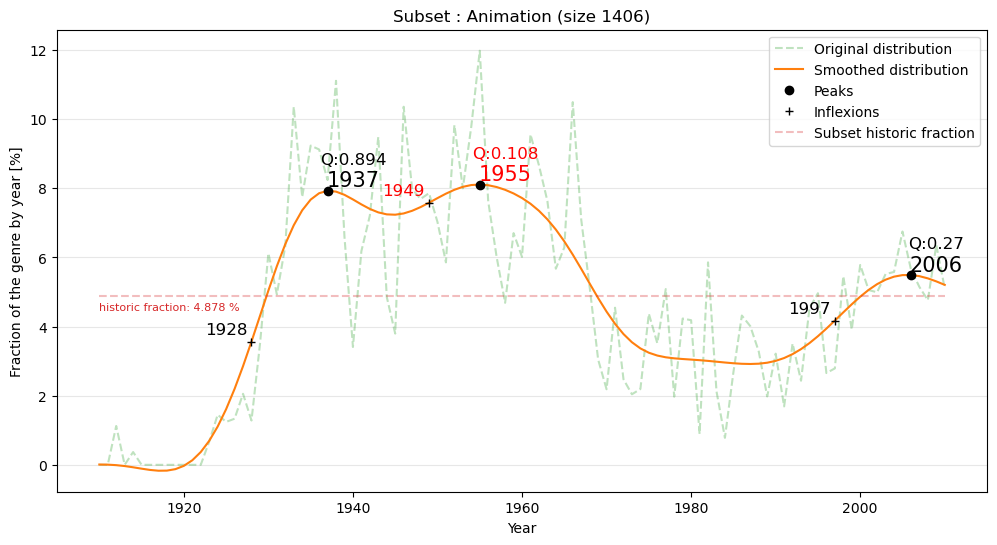

In [58]:
# Visualize trend detection for subset i
i = find_subset(subsets, 'Animation')

print('======== Subset {} ========'.format(subsets[i][0]))
print('Peaks: \t\t  {}'.format(get_peaks(movies, subsets, i)[0]))
print('Inflexion points: {}'.format(get_peaks(movies, subsets, i)[1]))
print('Quality of peaks: {}'.format(get_peaks(movies, subsets, i)[2]))

fig = viz_peaks(movies, subsets, i)

Same visualization, but for subsets of double genres.

======== Subset Double ('Action', 'Adventure') ========
Peaks: 		  [1937, 1952, 1985]
Inflexion points: [1928, 1948, 1979]
Quality of peaks: [0.6602947805607252, 0.048789334908421925, 0.13791540152232784]


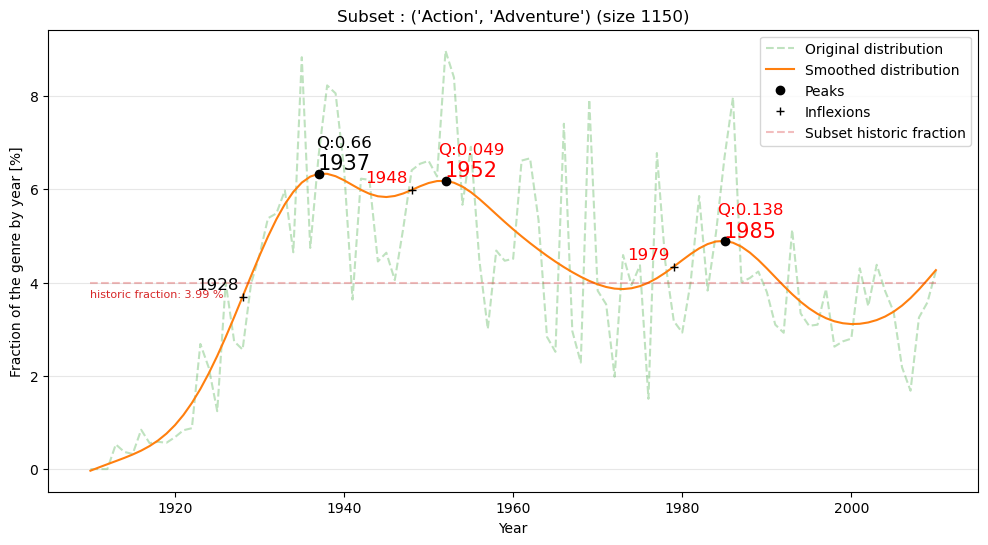

In [59]:
# Visualize trend detection for subset double i
i = find_subset_double(subsets_double, 'Adventure', 'Action')

print('======== Subset Double {} ========'.format(subsets_double[i][0]))
print('Peaks: \t\t  {}'.format(get_peaks(movies, subsets_double, i)[0]))
print('Inflexion points: {}'.format(get_peaks(movies, subsets_double, i)[1]))
print('Quality of peaks: {}'.format(get_peaks(movies, subsets_double, i)[2]))

fig = viz_peaks(movies, subsets_double, i)

We can save all trends visualizations as images by running the code below.

## 1.4) Construction of potential pivotal movie sets 
 

We have all the insights we want from our subsets. As mentionned before we suspect that the pivotal movie for a trend is hiding around the inflexion point. To be more precise we select a range before the inflexion, which size is the difference in years between the peak and the inflexion. Additionaly, we add a little margin range of 2 years after the inflexion, in case the previous method for smoothing the curve was a bit imprecise. Then from this range, we can select a tiny set of candidates for being pivotal to each trend.

In [61]:
candidates = get_candidates(subsets, trends)
candidates_double = get_candidates_double(subsets_double, trends_double)

print('Nb of sets of candidates: {}'.format(len(candidates)))
print('Format: list of ("genre_name", peak, inflexion, DF_candidates)')
print('Trend detection for first subset:')
display(candidates[0][0:3])
display(candidates[0][3])
print('Nb of sets of candidates double: {}'.format(len(candidates_double)))
print('Format: list of (("genre1_name","genre2_name"), peak, inflexion, DF_candidates)')
print('Trend detection for first subset double:')
display(candidates_double[0][0:3])
display(candidates_double[0][3])

Nb of sets of candidates: 387
Format: list of ("genre_name", peak, inflexion, DF_candidates)
Trend detection for first subset:


('Absurdism', 1977, 1965)

,id_wiki,id_freebase,name,year,revenue,runtime,lang,countries,genres
50941,1620938,/m/05hb3b,"What's Up, Tiger Lily?",1966,NaN,80.0,"[Japanese Language, English Language]","[USA, Japan]","[Parody, Absurdism, Japanese Movies, Comedy, Spy]"


Nb of sets of candidates double: 628
Format: list of (("genre1_name","genre2_name"), peak, inflexion, DF_candidates)
Trend detection for first subset double:


(('Action', 'Action Thrillers'), 1975, 1967)

,id_wiki,id_freebase,name,year,revenue,runtime,lang,countries,genres
5315,9176428,/m/027_856,The Chairman,1969,NaN,98.0,[English Language],"[USA, United Kingdom]","[Thriller, Action/Adventure, Action Thrillers,..."
20417,433285,/m/027ygy,Bullitt,1968,42300873.0,114.0,[English Language],[USA],"[Crime Fiction, Thriller, Chase Movie, Action ..."
25712,2184393,/m/06t66x,The Satan Bug,1965,NaN,114.0,[English Language],[USA],"[Action Thrillers, Science Fiction, Action, Ch..."
29942,5638224,/m/0dxmnh,The Born Losers,1967,36000000.0,113.0,[English Language],[USA],"[Crime Fiction, Thriller, Biker Film, Outlaw b..."
33341,3151903,/m/08vsry,Coogan's Bluff,1968,3110000.0,94.0,[English Language],[USA],"[Thriller, Crime Fiction, Chase Movie, Action ..."
41792,12147856,/m/02vrb9s,Shark!,1969,NaN,92.0,[English Language],"[Mexico, USA]","[Thriller, Action/Adventure, Indie, Action Thr..."
46038,1853855,/m/0615t5,They Saved Hitler's Brain,1966,NaN,91.0,[English Language],[USA],"[Thriller, Action Thrillers, Science Fiction, ..."
46410,22734911,/m/05zt443,The Helicopter Spies,1968,NaN,90.0,[English Language],[USA],"[Action Thrillers, Glamorized Spy Film, Action..."
70659,22557327,/m/05zv4pd,The Mini-Skirt Mob,1968,NaN,85.0,[English Language],[USA],"[Thriller, Action Thrillers, Biker Film, Outla..."


Let's see how it looks on the graph. You can change the peak year, or genre name to switch between visualizations of subsets.

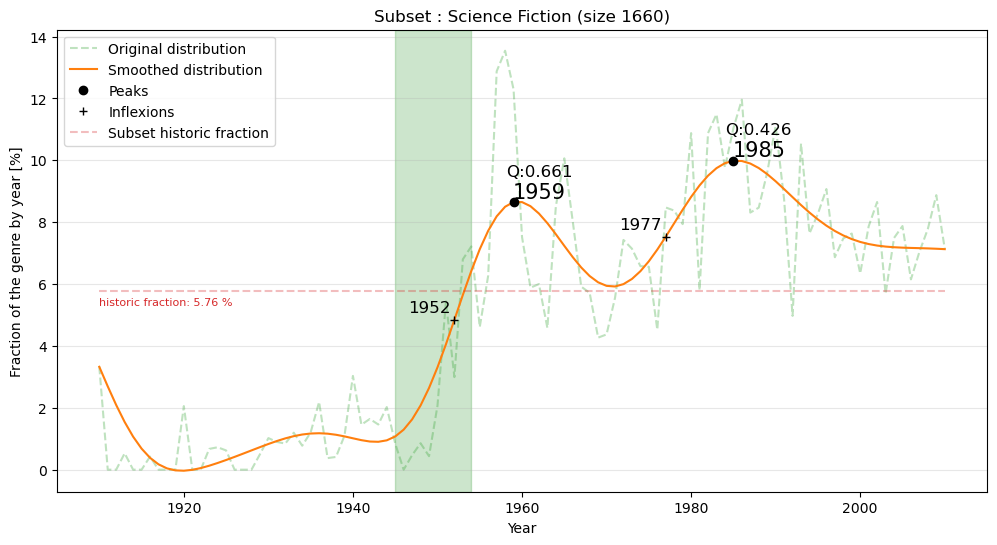

Candidates of pivotal of genre Science Fiction, for trend peak in 1959 and trend inflexion in 1952
Nb of candidates: 62


,id_wiki,id_freebase,name,year,revenue,runtime,lang,countries,genres
37427,14143898,/m/03cvyvb,The Monster and the Ape,1945,NaN,NaN,[English Language],[USA],"[Science Fiction, Sci-Fi Adventure, Adventure,..."
46748,8279491,/m/026ytcn,The Purple Monster Strikes,1945,NaN,NaN,[English Language],[USA],"[Science Fiction, Action, Adventure, Black-and..."
51709,11457604,/m/02rdfgc,Brick Bradford,1947,NaN,NaN,[English Language],[USA],"[Science Fiction, Action, Adventure, Black-and..."
32589,28387767,/m/0crgyyh,Unknown Island,1948,NaN,75.0,[English Language],[USA],"[Science Fiction, Action, Adventure]"
13194,6680124,/m/0gg_ry,Haredevil Hare,1948,NaN,NaN,[English Language],[USA],"[Short Film, Science Fiction, Family Film, Com..."
...,...,...,...,...,...,...,...,...,...
54770,6720101,/m/0gkfdj,Crash of Moons,1954,NaN,78.0,[English Language],[USA],"[Science Fiction, Indie, Black-and-white, Adve..."
16483,5609683,/m/0dw35q,The Snow Creature,1954,NaN,69.0,[English Language],[USA],"[Science Fiction, Horror, Creature Film]"
26322,72317,/m/0jhpk,Creature from the Black Lagoon,1954,1300000.0,80.0,[English Language],[USA],"[Monster movie, Science Fiction, Horror, Adven..."
25271,5516824,/m/0dqg_9,"20,000 Leagues Under the Sea",1954,11267000.0,122.0,[English Language],[USA],"[Science Fiction, Adventure, Action/Adventure,..."


In [62]:
show_candidates(movies, subsets, candidates, 'Science Fiction', peak='first')

Same visualization, but for subsets of double genres.

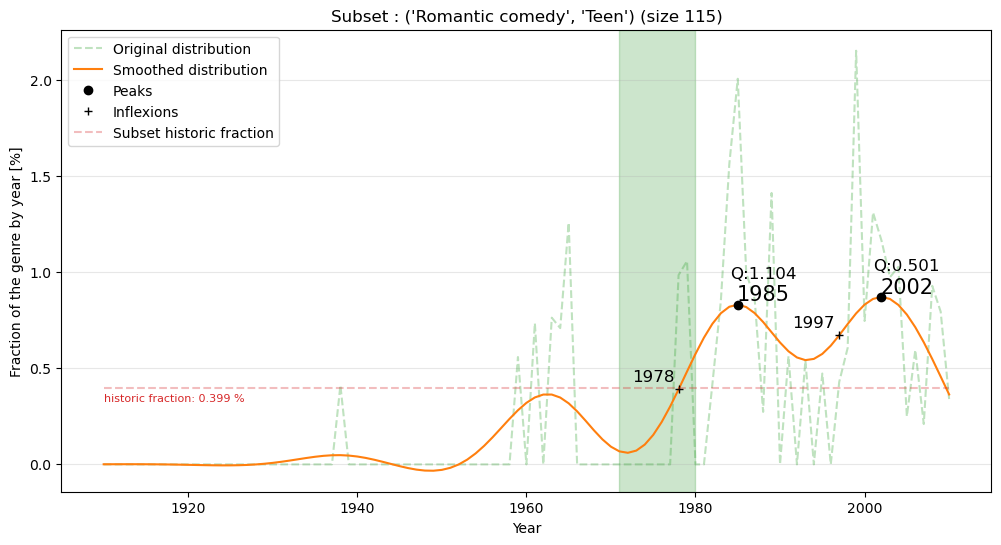

Candidates of pivotal of genre ('Romantic comedy', 'Teen'), for trend peak in 1985 and trend inflexion in 1978
Nb of candidates: 4


,id_wiki,id_freebase,name,year,revenue,runtime,lang,countries,genres
186,336846,/m/01xlqd,Grease,1978,394589888.0,225.0,[English Language],[USA],"[Romantic comedy, LGBT, Musical, Comedy, Roman..."
30248,3069423,/m/08pb5v,Corvette Summer,1978,NaN,105.0,[English Language],[USA],"[Romantic comedy, Adventure, Screwball comedy,..."
13257,1668076,/m/05l__x,A Little Romance,1979,NaN,110.0,"[French Language, English Language]","[France, USA]","[Romantic comedy, Romance Film, Coming of age,..."
14054,1369060,/m/04x8lh,Roller Boogie,1979,13253715.0,103.0,[English Language],[USA],"[Romantic comedy, Dance, Comedy-drama, Musical..."


In [63]:
show_candidates_double(movies, subsets_double, candidates_double, 'Romantic comedy', 'Teen', peak='first')

# 2) Metric assessment for Pivotal Movies identification

Identifying the pivotal movie, or the one that starts a trend, involves a combination of qualitative and quantitative analysis. Here are considerations and steps to help define the chosen pivotal movie within a specific genre:

- **Box-office Revenue :**
    Analyze the box-office performance of candidate movies within the subset. The pivotal movie often exhibits exceptional financial success, indicating a strong audience demand for the particular genre or theme. We need then to look for movies that surpassed industry expectations in terms of revenue. Also comparing the box-office performance of candidate movies to industry standards and consider their impact on subsequent films' budgeting and revenue expectations.

- **Ratings and votes :**
   Critical reception is a key indicator of a movie's impact and lasting influence. The pivotal movie should have received positive reviews from both critics and audiences, showcasing its quality and appeal. To this aims we incorporate a new dataset that includes review. These review will be a measuremnent of how good a movie is . This metric is fundamental to identify the pivotal movie : if a film is considered as bad there should be a lower chance that it influences the cinema industry and creating a trend. On the other hand, votes will evaluate the popularity of the movie.

- **Awards :**
Another measure for assessing influence is the recognition garnered through awards. Industry accolades serve as a validation of a movie's cultural and artistic significance. The receipt of awards signifies not only the excellence of the film but also its potential to set a standard worth emulating. It provides more precise insights into why the film is esteemed. Noteworthy awards include prestigious honors like the Oscars. In our analysis, we have opted to incorporate a dataset that encompasses these awards and their respective categories.

- **Plot Similarity:**
  This metric serves as an assessment of the extent to which a film influences others within the genre during trends. The concept is as follows: if the plot of a potential pivotal film closely resembles those observed in subsequent trend films when compared to other movies in the candidate subset, it indicates the film's influence on plot development. This similarity suggests that other films intentionally emulated the storyline, signifying the impactful nature of the pivotal film.



All these metrics will be exploited to select the pivotal film among the candidate subset. But to use it we need to properly define function which calculate from available data or simply add missing data from other dataset.


## 2.1) Completing Box-office revenue, ratings and number of votes

The first dataset we need to get in order is the BIG_IMDB one, containing data for 2.5 million movies and series, listed on the official website of IMDB.

In [65]:
IMDB_PATH = '/imdb_ratings_all_time/movies_imdb.csv'

imdb_vanilla = pd.read_csv(DATA_PATH+IMDB_PATH, usecols=['id', 'name', 'year', 'rating', 'duration', 'votes', 'gross_income'], low_memory=False)

# Let's quickly pre-process and clean the data
imdb_clean = imdb_vanilla.copy(deep=True)

# Let's get rid of the missing movie names
imdb_clean = imdb_vanilla.loc[~imdb_vanilla.name.isnull()]

imdb_clean = clean_imdb_data(imdb_clean)
imdb_clean = fuse_duplicates_imdb(imdb_clean)
imdb_clean = calculate_weighted_average(imdb_clean, 'name', 'rating', 'votes')

In [66]:
# Post wash-machine check
display(imdb_clean.sample(5))
display(imdb_clean.shape)
display(imdb_clean.info())
display(check_doublons(imdb_clean, col_check=['name'], year='year', runtime='duration'))

,id,name,year,rating,duration,votes,gross_income
144618,tt4068142,Here Today,2014,6.6,13.0,5.0,NaN
170736,tt2272998,Vessel,2013,6.6,100.0,33.0,NaN
135128,tt0065060,Trusting Is Good... Shooting Is Better,1968,4.6,106.0,131.0,NaN
188560,tt1740468,Amsterdam Heavy,2011,2.6,90.0,889.0,NaN
172939,tt0258253,Time with Nyenne,2000,7.7,26.0,16.0,NaN


(205729, 7)

<class 'pandas.core.frame.DataFrame'>
Index: 205729 entries, 0 to 214136
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            205729 non-null  object 
 1   name          205729 non-null  object 
 2   year          205729 non-null  object 
 3   rating        205729 non-null  float64
 4   duration      205729 non-null  float64
 5   votes         205729 non-null  float64
 6   gross_income  27934 non-null   float64
dtypes: float64(4), object(3)
memory usage: 12.6+ MB


None

No duplicates


'--------------------------------------------------------------------------------'

Now, let's load the IMDB_NAME_MAP dataset. If you are wondering why we bother adding this dataset to the mix, just wait to see what The West Bobers like to call the 'Star Wars problem'.

In [67]:
NAME_MAP_PATH = '/imdb_ratings_all_time/imdb_title_map.tsv'

name_map_vanilla = pd.read_csv(DATA_PATH+NAME_MAP_PATH, sep='\t', usecols=['tconst', 'primaryTitle', 'originalTitle', 'startYear', 'runtimeMinutes']).rename(columns={'originalTitle': 'name',
                                                                                                                                                        'startYear': 'year',
                                                                                                                                                        'runtimeMinutes': 'duration'})
# This dataframe is the key to overcome the "Star Wars" problem
# (ie: nomenclature changes for same movie across dataframes)
display(name_map_vanilla[name_map_vanilla['name']=='Star Wars'].head(1))
display(imdb_clean[imdb_clean['name']=='Star Wars'])
display(movies[movies['name'].str.contains('Star Wars Episode VI: Return of the Jedi')])

# Let's clean the dataset
name_map = name_map_vanilla.copy(deep=True)
name_map = clean_name_map(name_map_vanilla)

# Let's drop the doublons
name_map_clean = drop_duplicates(name_map, col_check=['name', 'year', 'duration'])

,tconst,primaryTitle,name,year,duration
75141,tt0076759,Star Wars: Episode IV - A New Hope,Star Wars,1977,121


,id,name,year,rating,duration,votes,gross_income
147390,tt0076759,Star Wars,1977,8.6,121.0,1332366.0,322740140.0


,id_wiki,id_freebase,name,year,revenue,runtime,lang,countries,genres
14376,50744,/m/0ddjy,Star Wars Episode VI: Return of the Jedi,1983,475106177.0,135.0,[English Language],[USA],"[Science Fiction, Adventure, Space opera, Fant..."


In [68]:
# Post wash-machine check
display(check_doublons(name_map_clean, col_check=['name'], year='year', runtime='duration'))
display(name_map_clean.info())

No duplicates


'--------------------------------------------------------------------------------'

<class 'pandas.core.frame.DataFrame'>
Index: 2526746 entries, 0 to 2644198
Data columns (total 5 columns):
 #   Column        Dtype  
---  ------        -----  
 0   tconst        object 
 1   primaryTitle  object 
 2   name          object 
 3   year          Int64  
 4   duration      float64
dtypes: Int64(1), float64(1), object(3)
memory usage: 118.1+ MB


None

Alright, everything looks ready to construct the ultimate IMDb D.O.A.T (Dataset Of All Time). It will complete imdb_clean with the alternative name of each movie. 

,alt_name,name,year,runtime,rating,votes,revenue
141635,Star Wars Episode IV A New Hope,Star Wars,1977,121.0,8.6,1332366.0,322740140.0


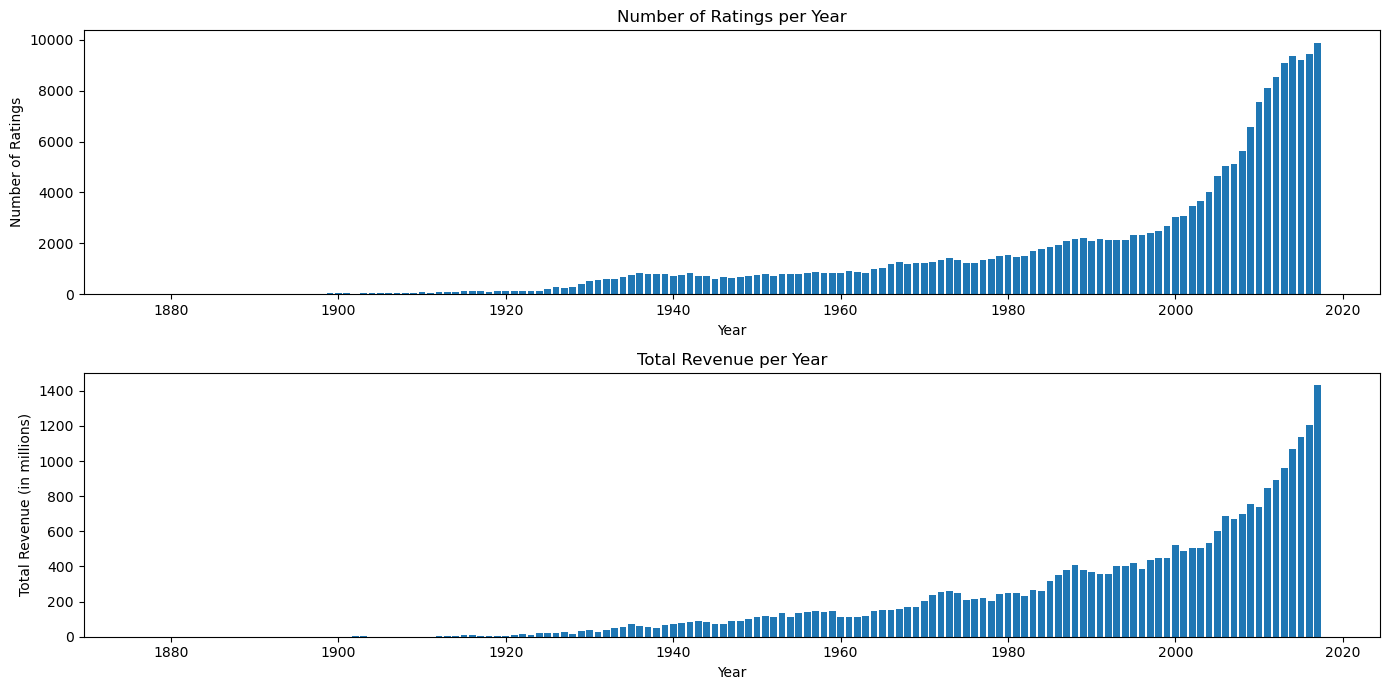

,alt_name,name,year,runtime,rating,votes,revenue
172489,Hand it Back,Hand it Back,2015,11.0,8.6,5.0,NaN
90454,Aerosmith Video Scrapbook,Aerosmith Video Scrapbook,1987,54.0,6.5,83.0,NaN
30254,The Veil,The Veil,2016,93.0,4.7,7773.0,NaN
26965,Supari The Quest Begins Now,Supari The Quest Begins Now,2014,90.0,6.4,37.0,NaN
55680,nan,謊言迷宮,2014,124.0,7.3,13176.0,794123.0


(205729, 7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205729 entries, 0 to 205728
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   alt_name  205729 non-null  object 
 1   name      205729 non-null  object 
 2   year      205729 non-null  object 
 3   runtime   205729 non-null  float64
 4   rating    205729 non-null  float64
 5   votes     205729 non-null  float64
 6   revenue   27934 non-null   float64
dtypes: float64(4), object(3)
memory usage: 11.0+ MB


None

In [69]:
# Merging imdb_clean and name_map_clean to obtain the final IMDb dataframe
imdb_final = pd.merge(name_map_clean, imdb_clean, on=['name', 'year', 'duration'], how='right').drop(columns={'tconst', 'id'}).rename(columns={'primaryTitle': 'alt_name',
                                                                                                                                                'duration': 'runtime', 
                                                                                                                                                'gross_income': 'revenue'})
# To make it ready for future merges: clean the names to get rid of some characters and trailing white spaces
imdb_final = clean_column_str(imdb_final, 'alt_name')
imdb_final = clean_column_str(imdb_final, 'name')

# 'Star Wars problem' is solved
display(imdb_final[imdb_final['name']=='Star Wars'])

# Let's check the yearly distribution of ratings and revenues in the imdb_final dataframe
plot_yearly_distribution_imdb(imdb_final)

# Post wash-machine check
display(imdb_final.sample(5))
display(imdb_final.shape)
display(imdb_final.info())
                                                                                

Nice, now the imdb_final is ready. Let's enhance it further with the cleaned Movie Lens dataset (Milestone 2 was not that useless, it turns out).

In [70]:
# Loading the cleaned movie_lens dataframe from Milestone 2
movies_lens = movies_lens.rename(columns={'review': 'rating', 'nbr_review': 'votes'})

# To make it ready for future merges: clean the names to get rid of some characters and trailing white spaces
movies_lens = clean_column_str(movies_lens, 'name')

# Merging imdb_final and movies_lens to get annex data
annex = pd.merge(movies_lens, imdb_final, on=['name', 'year', 'runtime'], how='right')

# Need to pre-process some datas: fuse the revenue columns, fuse the rating and votes columns,
# adress the alt_name nan issue and fuse the duplicates
annex_merge = annex.copy(deep=True)
annex_merge = fuse_and_clean_annex(annex_merge)

# Post wash-machine check
display(check_doublons(annex_merge, ['alt_name'], 'year', 'runtime'))
display(check_doublons(annex_merge, ['name'], 'year', 'runtime'))
display(annex_merge.sample(5))
display(annex_merge.shape)
display(annex_merge.info())

Fusing duplicates: 
Duplicates fused successfully.
--------------------------------------------------------------------------------
Fusing duplicates: 
Duplicates fused successfully.
--------------------------------------------------------------------------------
No duplicates


'--------------------------------------------------------------------------------'

No duplicates


'--------------------------------------------------------------------------------'

,runtime,name,year,alt_name,revenue,rating,votes
32139,95.0,Pumpkinhead 4 Blood Feud,2007,Pumpkinhead 4 Blood Feud,NaN,4.3,2232.0
166580,122.0,Fireproof,2008,Fireproof,33456317.0,6.4,22902.0
172173,79.0,Kdyz se certi rojili,1966,Kdyz se certi rojili,NaN,5.8,5.0
185619,98.0,Romance Policial,2012,Romance Policial,NaN,6.0,69.0
52081,5.0,The Reunion,2015,The Reunion,NaN,8.5,6.0


(205269, 7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205269 entries, 0 to 205268
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   runtime   205269 non-null  float64
 1   name      205269 non-null  object 
 2   year      205269 non-null  object 
 3   alt_name  205269 non-null  object 
 4   revenue   27972 non-null   float64
 5   rating    205269 non-null  float64
 6   votes     205269 non-null  float64
dtypes: float64(4), object(3)
memory usage: 11.0+ MB


None

This far, we have captured the informations contained in IMDb and Movie Lens. It is time to use them to complete the dataframe movies.

In [71]:
# To make movies ready for future merges: clean the names to get rid of some characters and trailing white spaces
movies_merge = movies.copy(deep=True).reset_index(drop=True)
movies_merge = clean_column_str(movies_merge, 'name')

# Let's complete movies_merge with data from annex_merge
movies3_vanilla = pd.merge(annex_merge, movies_merge, left_on=['alt_name', 'year'], right_on=['name', 'year'], how='right')

# Need to clean merged dataframe
movies3 = movies3_vanilla.copy(deep=True)

# For some reason, annex revenue tends to underestimate movies3 revenue
compare_revenue_columns(movies3_vanilla, 'revenue_x', 'revenue_y')

# Let's scale underestimated revenues
movies3 = scale_and_fuse_revenue(
    df=movies3,
    col_to_scale='revenue_x',
    col_reference='revenue_y',
    new_col_name='revenue',
    drop_cols=['runtime_x', 'alt_name', 'revenue_x', 'revenue_y'],
    rename_cols={'runtime_y': 'runtime', 'name_x': 'alt_name', 'name_y': 'name'}
)

# Complete missing alt_name
movies3['alt_name'] = movies3['alt_name'].replace('nan', None)
movies3['alt_name'].fillna(movies3['name'], inplace=True)


The percentage of times 'revenue_x' is higher than 'revenue_y' when both are not NaN is: 12.93%
The percentage of times 'revenue_x' is lower than 'revenue_y' when both are not NaN is: 62.20%
The percentage of times 'revenue_x' is equal to 'revenue_y' when both are not NaN is: 24.87%
The scaling factor is: 1.351464995146241


In [72]:
# Post wash-machine check
display(movies3.sample(5))
display(movies3.info())

,alt_name,year,rating,votes,id_wiki,id_freebase,name,runtime,lang,countries,genres,revenue
4644,Puppet Master The Legacy,2004,NaN,NaN,7154803,/m/0h7572,Puppet Master The Legacy,85.0,[English Language],[USA],[Horror],<NA>
8215,Call of the Yukon,1938,5.4,143.0,23881223,/m/076yw7p,Call of the Yukon,57.0,[English Language],[USA],"[Thriller, Horror, Adventure, Black-and-white,...",<NA>
28357,The Crazy World of Julius Vrooder,1974,NaN,NaN,24423022,/m/07scndl,The Crazy World of Julius Vrooder,98.0,[English Language],[USA],"[Drama, Comedy-drama, Comedy]",<NA>
8896,"Dr. Black, Mr. Hyde",1976,NaN,NaN,6030385,/m/0flftv,"Dr. Black, Mr. Hyde",87.0,[English Language],[USA],"[Blaxploitation, Horror]",<NA>
20385,Tarzan Triumphs,1943,6.2,2167.0,17120190,/m/043q1hn,Tarzan Triumphs,76.0,[English Language],[USA],"[Adventure, Black-and-white]",3270000.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29051 entries, 0 to 29050
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   alt_name     29051 non-null  object 
 1   year         29051 non-null  object 
 2   rating       14650 non-null  float64
 3   votes        14650 non-null  float64
 4   id_wiki      29051 non-null  int64  
 5   id_freebase  29051 non-null  object 
 6   name         29051 non-null  object 
 7   runtime      25936 non-null  float64
 8   lang         29051 non-null  object 
 9   countries    29051 non-null  object 
 10  genres       29051 non-null  object 
 11  revenue      10731 non-null  object 
dtypes: float64(3), int64(1), object(8)
memory usage: 2.7+ MB


None

Although we now have a pretty solid dataframe, informations of some important movies might still be missing. That is why it is time to merge movies3 with the cleaned moviestats from Milestone 2. Since moviestats is obtained by scrapping the IMDb website, a particular attention is given to only take into account moviestats data when movies3 data is missing. This way, we do not consider the same data twice. 

At the end, we obtain all the Box office revenue, rating and votes data needed to carry the project.

In [73]:
# Some renowned movies are still missing, so let's incorporate movies_stats dataframe
movies_stats = movies_stats.rename(columns={'review': 'rating', 'nbr_review': 'votes'})

# To make movies ready for future merges: clean the names to get rid of some characters and trailing white spaces
movies_stats = clean_column_str(movies_stats, 'name')

# Completing movies3 with movies_stats to obtain movies3_stats
movies3_stats = pd.merge(movies_stats, movies3, on=['name', 'year'], how='right')

# Before fusing them, need to compare revenue_x and revenue_y
compare_revenue_columns(movies3_stats, 'revenue_x', 'revenue_y')
# Moviestats is more evenly distributed so no scaling factor needed 

# Let's pre-process movies3_stats to fuse revenue, rating and votes 
# and to keep only rows where revenue & votes are available
movies3_stats_clean = process_movies3_stats(movies3_stats).reset_index(drop=True)

# Post wash-machine check
display(movies3_stats_clean.sample(5))
display(movies3_stats_clean.info())

The percentage of times 'revenue_x' is higher than 'revenue_y' when both are not NaN is: 32.94%
The percentage of times 'revenue_x' is lower than 'revenue_y' when both are not NaN is: 28.60%
The percentage of times 'revenue_x' is equal to 'revenue_y' when both are not NaN is: 38.46%


,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,revenue
5521,Vanishing Point,1971,Vanishing Point,7.2,28665.0,1358857,/m/04wjsn,106.0,[English Language],"[USA, United Kingdom]","[Thriller, Cult, Road movie, Existentialism, A...",28788221.0
1442,Body Snatchers,1993,Body Snatchers,6.0,19591.0,5735467,/m/0f1yxp,87.0,[English Language],[USA],"[Thriller, Science Fiction, Horror, Alien Film...",428868.0
6969,Teaching Mrs. Tingle,1999,Teaching Mrs. Tingle,5.3,20861.0,781219,/m/03bxbk,95.0,[English Language],[USA],"[Thriller, Comedy Thriller, Suspense, Black co...",8946237.0
3288,Nightmares,1983,Nightmares,5.7,3321.0,2276238,/m/0705k1,99.0,[English Language],[USA],"[Thriller, Science Fiction, Horror]",6670680.0
1616,The Wolf Man,1941,The Wolf Man,7.2,26801.0,927058,/m/03qpr2,71.0,[English Language],[USA],"[Drama, Tragedy, Horror, Black-and-white]",32516.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9496 entries, 0 to 9495
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         9496 non-null   object 
 1   year         9496 non-null   object 
 2   alt_name     9496 non-null   object 
 3   rating       9496 non-null   float64
 4   votes        9496 non-null   float64
 5   id_wiki      9496 non-null   int64  
 6   id_freebase  9496 non-null   object 
 7   runtime      9395 non-null   float64
 8   lang         9496 non-null   object 
 9   countries    9496 non-null   object 
 10  genres       9496 non-null   object 
 11  revenue      9496 non-null   object 
dtypes: float64(3), int64(1), object(8)
memory usage: 890.4+ KB


None

## 2.2) Incorporating the Oscar dataset

In [74]:
# Let's load the award dataset
AWARDS_PATH = '/awards/oscars.csv'
awards = pd.read_csv(DATA_PATH+AWARDS_PATH).rename(columns={'year_film': 'year', 'category': 'cat_nominated', 'name': 'name_nominated', 'film': 'name'}).drop(columns=['ceremony', 'year_ceremony', 'cat_nominated', 'name_nominated'])

# Need some preprocessing: get rid of missing name rows, 
# make the names consistent for future merges and condense the dataframe to get all information available per unique movie
awards_condensed = clean_and_condense_awards(awards)

# Post wash-machine check
display(awards_condensed.sample(5))
display(awards_condensed.shape)
display(awards_condensed.info())

,name,year,winner
2256,Marriage Italian Style,1965,[False]
4691,Topkapi,1964,[True]
2639,Otello,1986,[False]
4903,Waterworld,1995,[False]
5040,Wrestling Swordfish,1931,[True]


(5098, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5098 entries, 0 to 5097
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    5098 non-null   object
 1   year    5098 non-null   int64 
 2   winner  5098 non-null   object
dtypes: int64(1), object(2)
memory usage: 119.6+ KB


None

Now, we need to merge awards_condensed into movies3_stats_clean. The issue is that some names in awards_condensed match with column name of movies3_stats_clean, others with column alt_name.
Therefore, the plan is: 

1) Get two intermediate merges 

2) Merge them and fuse winner column to obtain final merge

In [75]:
movies_features_1 = pd.merge(movies3_stats_clean, awards_condensed, 
                               left_on=['name', 'year'], 
                               right_on=['name', 'year'], 
                               how='left')

movies_features_2 = pd.merge(movies3_stats_clean, awards_condensed, 
                               left_on=['alt_name', 'year'], 
                               right_on=['name', 'year'], 
                               how='left').drop(columns=['name_y']).rename(columns={'name_x': 'name'})

# Final award merge
movies_features_inc = pd.merge(
    movies_features_1,
    movies_features_2,
    on=['id_wiki', 'id_freebase', 'name', 'alt_name', 'year', 'runtime', 'revenue', 'votes', 'rating'],  
    how='inner').drop(columns=['lang_y', 'countries_y', 'genres_y']).rename(columns={'lang_x': 'lang', 'countries_x': 'countries', 'genres_x': 'genres'})

movies_features_inc = fuse_winner_columns(movies_features_inc, 'winner_x', 'winner_y')

# Let's fuse the duplicates
while not movies_features_inc[movies_features_inc.duplicated(['name', 'year', 'runtime'], keep=False)].empty:
    movies_features_inc = fuse_duplicates_v2(df=movies_features_inc, col_check=['name'], year='year', runtime='runtime', col_null=['revenue'], col_score='rating', col_weight='votes')

# Did it work?
display(check_doublons(movies_features_inc, col_check=['name'], year='year', runtime='runtime'))
# Yes!

# Create column to check if a movie has won an Oscar
movies_features_inc['has_won'] = movies_features_inc['winner'].apply(lambda x: True if isinstance(x, list) and True in x else False)

# Create column to check if a movie has been nominated for an Oscar
movies_features_inc['nominated'] = movies_features_inc['winner'].apply(lambda x: True if isinstance(x, list) else False)

# Create column to store how many Oscars a movie has won
movies_features_inc['nbr_won'] = movies_features_inc['winner'].apply(lambda x: x.count(True) if isinstance(x, list) else 0)

# Create column to store how many Oscars a movie has been nominated for
movies_features_inc['nbr_nomination'] = movies_features_inc['winner'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# Post wash-machine check
display(movies_features_inc.sample(5))
display(movies_features_inc.shape)
display(movies_features_inc.info())

Fusing duplicates: 
Duplicates fused successfully.
--------------------------------------------------------------------------------
Fusing duplicates: 
Duplicates fused successfully.
--------------------------------------------------------------------------------
Fusing duplicates: 
Duplicates fused successfully.
--------------------------------------------------------------------------------
No duplicates


'--------------------------------------------------------------------------------'

,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,revenue,winner,has_won,nominated,nbr_won,nbr_nomination
7802,50 First Dates,2004,50 First Dates,6.8,335000.0,477099,/m/02f6g5,99.0,"[Turkish Language, Standard Mandarin, English ...",[USA],"[Romantic comedy, Romance Film, Comedy]",196482882.0,NaN,False,False,0,0
2997,Johnny Tremain,1957,Johnny Tremain,6.5,1788.0,5877549,/m/0fbckx,80.0,[English Language],[USA],"[Adventure, Historical fiction, Drama, War fil...",24514.0,NaN,False,False,0,0
5249,Winchester '73,1950,Winchester '73,7.6,19785.0,1024760,/m/03_91z,93.0,[English Language],[USA],"[Action/Adventure, Western]",3375000.0,NaN,False,False,0,0
7018,The Last Days of Disco,1998,The Last Days of Disco,6.7,13415.0,2995062,/m/08jfdl,114.0,[English Language],[USA],"[Parody, Ensemble Film, Indie, Comedy of manne...",3528914.162803,NaN,False,False,0,0
545,Invaders from Mars,1953,Invaders from Mars,6.3,7919.0,2393932,/m/078ztb,71.0,[English Language],[USA],"[Alien invasion, Thriller, Science Fiction]",13906.0,NaN,False,False,0,0


(9427, 17)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9427 entries, 0 to 9426
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            9427 non-null   object 
 1   year            9427 non-null   object 
 2   alt_name        9427 non-null   object 
 3   rating          9427 non-null   float64
 4   votes           9427 non-null   float64
 5   id_wiki         9427 non-null   int64  
 6   id_freebase     9427 non-null   object 
 7   runtime         9326 non-null   object 
 8   lang            9427 non-null   object 
 9   countries       9427 non-null   object 
 10  genres          9427 non-null   object 
 11  revenue         9427 non-null   object 
 12  winner          1388 non-null   object 
 13  has_won         9427 non-null   bool   
 14  nominated       9427 non-null   bool   
 15  nbr_won         9427 non-null   int64  
 16  nbr_nomination  9427 non-null   int64  
dtypes: bool(2), float64(2), int64(3),

None

That's all folks! We succesfully created a clean dataframe with enough data to carry the next analyses! Let's now... uh oh, what is this ? Did our small nerd engineer brains forget some important aspect of the real world? 

## 2.3) Adjusting for inflation & normalizing revenue

#### US dollar inflation
In the dataset, the revenues of the movies are included, in US dollars. Due to inflation, one dollar in 1914 (the earliest date of release for a movie in the dataset) compared to one dollar in 2012 (the most recent movie in the dataset) is not worth the same. The purchasing power of the money has changed and this effect has to be accounted for, if two movies from different moments in time should be compared to each other. The effect of inflation can be accounted for with an additional [dataset](https://www.officialdata.org/us/inflation/1800?amount=1#buying-power), relating the worth of US dollar in each year to the worth of US dollar in 1800:

In [77]:
INFLATION_PATH = '/inflation/inflation_data.csv'

inflation_raw= pd.read_csv(DATA_PATH+INFLATION_PATH)
display(inflation_raw.sample(5))
display(inflation_raw.shape)
display(inflation_raw.info())

,year,amount,inflation rate
171,1971,3.21,0.04
85,1885,0.77,-0.01
8,1808,1.00,0.09
169,1969,2.91,0.05
131,1931,1.21,-0.09


(224, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224 entries, 0 to 223
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            224 non-null    int64  
 1   amount          224 non-null    float64
 2   inflation rate  224 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 5.4 KB


None

,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,revenue,winner,has_won,nominated,nbr_won,nbr_nomination,revenue_infl
5345,"Dance, Girl, Dance",1940,"Dance, Girl, Dance",6.8,2664.0,12450050,/m/02w6gl4,89.0,[English Language],[USA],"[Black-and-white, Musical, Drama, Comedy, Roma...",2507106.0,NaN,False,False,0,0,2258654.054054
554,Stir of Echoes,1999,Stir of Echoes,6.9,81443.0,1577984,/m/05cx06,94.0,[English Language],[USA],"[Thriller, Horror, Supernatural, Psychological...",21133087.0,NaN,False,False,0,0,1598569.364599
3138,The Last Sentinel,2007,The Last Sentinel,3.5,1748.0,15974185,/m/03qjnnw,94.0,[English Language],[USA],"[Thriller, Action Thrillers, Science Fiction, ...",62480.0,NaN,False,False,0,0,3795.868773
7353,The Barkleys of Broadway,1949,The Barkleys of Broadway,7.0,3176.0,3497579,/m/09gr4b,109.0,[English Language],[USA],"[Romantic comedy, Musical, Musical comedy, Rom...",2319166.55532,[False],False,True,0,1,1227072.251492
890,Cairo,1942,Cairo,6.1,460.0,21742948,/m/05mv1f7,101.0,[English Language],[USA],"[Comedy, Black-and-white]",616000.0,NaN,False,False,0,0,477519.379845


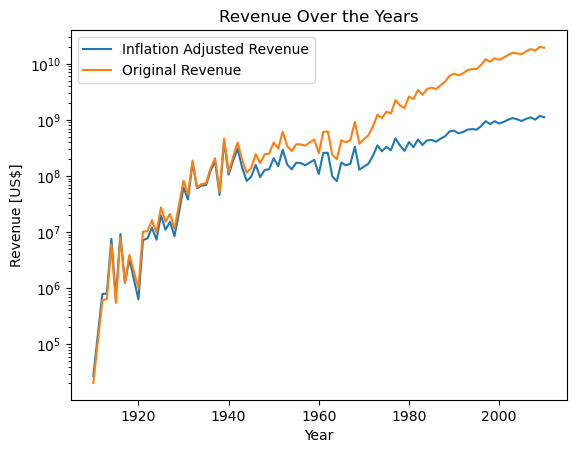

In [78]:
df_inflation = revenue_inflation_correction(movies_features_inc, inflation_raw)

In [79]:
df_inflation[df_inflation['year'] == 1915]

,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,revenue,winner,has_won,nominated,nbr_won,nbr_nomination,revenue_infl
292,Kindling,1915,Kindling,6.6,31.0,14626970,/m/03gr3s9,<NA>,"[Silent film, English Language]",[USA],"[Crime Fiction, Silent film, Drama, Indie, Bla...",66036.0,NaN,False,False,0,0,82545.0
1298,The Captive,1915,The Captive,6.5,128.0,14616918,/m/03gqqyf,50.0,"[Silent film, English Language]",[USA],"[Silent film, Romance Film, Drama, Indie, Blac...",56075.0,NaN,False,False,0,0,70093.75
1851,The Warrens of Virginia,1915,The Warrens of Virginia,5.9,23.0,14616220,/m/03gqq2m,<NA>,"[Silent film, English Language]",[USA],"[Silent film, Drama, Indie, Black-and-white]",85770.0,NaN,False,False,0,0,107212.5
2484,The Arab,1915,The Arab,5.1,49.0,14617357,/m/03gqrgm,50.0,"[Silent film, English Language]",[USA],"[Silent film, Adventure, Black-and-white, Indie]",68527.0,NaN,False,False,0,0,85658.75
5464,Chimmie Fadden Out West,1915,Chimmie Fadden Out West,4.9,23.0,14627259,/m/03gr45c,50.0,"[Silent film, English Language]",[USA],"[Silent film, Western, Indie, Black-and-white,...",72036.0,NaN,False,False,0,0,90045.0
6095,Alice in Wonderland,1915,Alice in Wonderland,6.2,516.0,23669602,/m/06zr25h,52.0,[English Language],[USA],"[Silent film, Black-and-white]",97477.0,NaN,False,False,0,0,121846.25
8989,The Girl of the Golden West,1915,The Girl of the Golden West,5.4,55.0,14614654,/m/03gqn62,50.0,"[Silent film, English Language]",[USA],"[Silent film, Western, Black-and-white, Indie]",102224.0,NaN,False,False,0,0,127780.0


The very high total revenue in the year 1915 catches the eye, but the data for it is valid. In 1915 the movie "The Birth of a Nation" was released, which is a movie that was extremely succesful and had a box office revenue of about [50-100 Mio US$ (Wikipedia)](https://en.wikipedia.org/wiki/The_Birth_of_a_Nation). 

### Normalization for counterbalancing natural growth of movie industry

The steady increase in total revenue over time can be explained partly by the ever increasing number of movies released per year. One should however also consider the steady growth of the movie industry, which allows a movie to make much more revenue today (with an international distribution of the movies) as opposed to earlier in time. This effect should be taken into consideration, which is why we perform a regression analysis and normalize the data accordingly:

In [80]:
df_inflation['revenue_part'] = df_inflation.groupby('year')['revenue'].transform(lambda x: x / x.sum())
display(df_inflation.sample(5))
display(df_inflation.shape)
display(df_inflation.info())

,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,revenue,winner,has_won,nominated,nbr_won,nbr_nomination,revenue_infl,revenue_part
6291,The Squeeze,1987,The Squeeze,4.71,1213.0,10459622,/m/02qdt7z,101.0,[English Language],[USA],"[Thriller, Comedy]",2228951.0,NaN,False,False,0,0,247112.084257,0.000537
6626,Rocky IV,1985,Rocky IV,6.80,203366.0,104984,/m/0q9sg,91.0,"[English Language, Russian Language]",[USA],"[Sports, Action, Drama, Political drama, Boxing]",294960998.027196,NaN,False,False,0,0,34538758.551194,0.078736
8539,Last Train from Gun Hill,1959,Last Train from Gun Hill,7.30,7834.0,14092400,/m/03ct9vn,94.0,[English Language],[USA],"[Action/Adventure, Western]",2500000.0,NaN,False,False,0,0,1082251.082251,0.005579
4240,Jesse Stone Thin Ice,2009,Jesse Stone Thin Ice,7.10,3689.0,27634879,/m/0c3_myq,90.0,[English Language],[USA],"[Crime Fiction, Thriller, Television movie, Dr...",20100000.0,NaN,False,False,0,0,1180270.111568,0.001006
1245,The Wings of the Dove,1997,The Wings of the Dove,7.10,11000.0,3751746,/m/09z2b7,101.0,[English Language],"[USA, United Kingdom]","[Indie, Period piece, Drama, Film adaptation, ...",13692848.0,"[False, False, False, False]",False,True,0,4,1074791.836735,0.001133


(9427, 19)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9427 entries, 0 to 9426
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            9427 non-null   object 
 1   year            9427 non-null   object 
 2   alt_name        9427 non-null   object 
 3   rating          9427 non-null   float64
 4   votes           9427 non-null   float64
 5   id_wiki         9427 non-null   int64  
 6   id_freebase     9427 non-null   object 
 7   runtime         9326 non-null   object 
 8   lang            9427 non-null   object 
 9   countries       9427 non-null   object 
 10  genres          9427 non-null   object 
 11  revenue         9427 non-null   object 
 12  winner          1388 non-null   object 
 13  has_won         9427 non-null   bool   
 14  nominated       9427 non-null   bool   
 15  nbr_won         9427 non-null   int64  
 16  nbr_nomination  9427 non-null   int64  
 17  revenue_infl    9427 non-null   o

None

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.505
Model:                            OLS   Adj. R-squared (uncentered):              0.500
Method:                 Least Squares   F-statistic:                              100.1
Date:                Fri, 22 Dec 2023   Prob (F-statistic):                    1.17e-16
Time:                        22:40:21   Log-Likelihood:                         -2081.4
No. Observations:                  99   AIC:                                      4165.
Df Residuals:                      98   BIC:                                      4167.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,revenue,winner,has_won,nominated,nbr_won,nbr_nomination,revenue_infl,revenue_part,revenue_norm
2271,The Last Airbender,2010,The Last Airbender,4.01,163824.0,16963505,/m/05qbbfb,103.0,[English Language],[USA],"[Science Fiction, Fantasy Comedy, Adventure, S...",311919610.457147,NaN,False,False,0,0,18019619.321615,0.016133,17747851.475607
8803,Tangled,2010,Tangled,7.90,16.0,619728,/m/02xbyr,100.0,[English Language],[USA],"[Computer Animation, Animation, Revisionist Fa...",590721936.0,[False],False,True,0,1,34126050.606586,0.030554,33611369.186265
6392,ScoobyDoo! Camp Scare,2010,ScoobyDoo! Camp Scare,7.20,3327.0,28014365,/m/0cryrdw,77.0,[English Language],[USA],"[Family Film, Adventure, Animation]",3924000.0,NaN,False,False,0,0,226689.774697,0.000203,223270.890497
6746,Bad Company,1972,Bad Company,7.00,4208.0,5579768,/m/0dtkjm,92.0,[English Language],[USA],"[Action/Adventure, Acid western, Western, Action]",4940939.0,NaN,False,False,0,0,1488234.638554,0.006518,1420161.52924
134,Fire with Fire,1986,Fire with Fire,6.50,1500.0,12180811,/m/02vt7xf,104.0,[English Language],[USA],"[Crime Fiction, Melodrama, Drama, Romantic dra...",4636000.0,NaN,False,False,0,0,532873.563218,0.001307,516147.00368


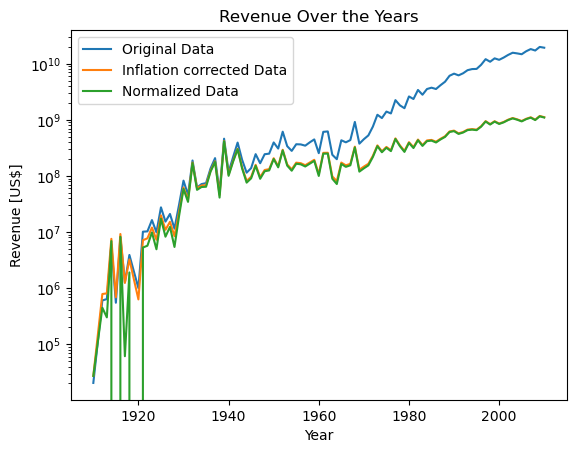

In [81]:
movies_features = df_inflation.copy(deep=True)
movies_features = revenue_normalisation(df_inflation).drop(columns=['winner', 'revenue_infl', 'revenue'])

## 2.4) Plot similarity

As mentioned before, we're aiming to establish a measure to determine whether a selected movie influences other films within the same genre post-trend. To achieve this, we utilize the plots of movies obtained from Wikipedia. The goal is to develop a tool that allows us to assess similarities between movie plots. Essentially, if the plots of two different movies are highly alike, we can infer that one movie may have inspired the other. By generalizing to multiple movie we could find which movie inspire the one of the trend. To assessthe plot similarity we will NLP method.

 - Before analyse plot similarity we need to **load** the dataset and **merge** it with movies clean dataframe.

In [82]:
MOVIES_PLOT = MOVIES_FOLDER + "plot_summaries.txt"
df_plot = pd.read_csv(MOVIES_PLOT, sep='\t', names=['id_wiki', 'plot'])

merged_df = df_plot.merge(movies, on='id_wiki')
merged_df.columns
display(merged_df)


,id_wiki,plot,id_freebase,name,year,revenue,runtime,lang,countries,genres
0,2231378,"The Lemon Drop Kid , a New York City swindler,...",/m/06xtz3,The Lemon Drop Kid,1951,2300000.0,91.0,[English Language],[USA],"[Screwball comedy, Comedy]"
1,595909,Seventh-day Adventist Church pastor Michael Ch...,/m/02tqm5,A Cry in the Dark,1988,6908797.0,121.0,[English Language],"[USA, Australia, New Zealand]","[Crime Fiction, Drama, Docudrama, World cinema..."
2,5272176,The president is on his way to give a speech. ...,/m/0dbxtv,End Game,2006,NaN,93.0,[English Language],"[USA, Canada, Germany]","[Thriller, Action/Adventure, Action, Drama]"
3,1952976,"{{plot}} The film opens in 1974, as a young gi...",/m/068jvg,Dark Water,2005,49483352.0,105.0,[English Language],[USA],"[Thriller, Drama, Horror]"
4,24225279,"The story begins with Hannah, a young Jewish t...",/m/07kbs3s,Sing,1989,2260616.0,98.0,[English Language],[USA],"[Drama, Teen]"
...,...,...,...,...,...,...,...,...,...,...
18166,11957333,Clarence Mumford is a Robitussin addict living...,/m/02rzlj4,Ninja Bachelor Party,1991,NaN,30.0,[English Language],[USA],"[Parody, Indie, Absurdism, Action Comedy, Shor..."
18167,26261438,While drinking alone one night and reminiscing...,/m/0b76dxj,Outlaw of Gor,1989,NaN,89.0,[English Language],[USA],"[Science Fiction, Fantasy Adventure, Adventure]"
18168,17208834,A high school prom in Georgia is unexpectedly ...,/m/04ydw1v,Dance of the Dead,2008,NaN,87.0,[English Language],[USA],"[Zombie Film, Horror, Indie, Teen, Comedy]"
18169,2867597,"An attempt to bring the famed ""Mr. Bill"" clay ...",/m/087whb,Mr. Bill's Real Life Adventures,1986,NaN,43.0,[English Language],[USA],"[Comedy, Slapstick]"


### *Tokenization, removing the stop words and stemming*



To figure out if plots are similar, we use text analysis, which involves a few steps.

-  First, we break down each plot into separate words. After that, we get rid of the words like 'and,' 'but,' in' (a.k.a stopwords) they're common but don't give much info about the plot. Moreover we also remove punction of the plot that is only use to fluidify the reading.

- Once we remove stopwords, we then simplify each word through a process called stemming. Stemming is the process of simplifying words to their base or root form, facilitating the grouping of different word variations with similar meanings.For example we can convert words like "running" or "runner" to the root "run."

- Finally we make a tokenization  that involves breaking down a text into smaller units, often words or phrases referred to as tokens. In our context, after the initial text processing steps, each remaining word can be considered a token. 

Here is a quick example of with on of the favorites quote of our wrestler : *"In the ring, I am a force to be reckoned with. My strength and determination know no bounds. I'll crush any opponent who dares to step into my territory."*

In [83]:
# Example plot
original_plot = "In the ring, I am a force to be reckoned with. My strength and determination know no bounds. I'll crush any opponent who dares to step into my territory."


# Remove stopwords and punctuation

plot_without_stopwords_and_punctuation = remove_stopwords_and_punctuation(original_plot)

# Apply stemming
speech_after_stemming = apply_stemming(plot_without_stopwords_and_punctuation)


print("Original Plot:")
print(original_plot)

print("\nPlot After Removing Stopwords and Punctuation:")
print(" ".join(plot_without_stopwords_and_punctuation))

print("\nSpeech After Removing Stopwords, Punctuation, and Stemming:")
print(" ".join(speech_after_stemming))

Original Plot:
In the ring, I am a force to be reckoned with. My strength and determination know no bounds. I'll crush any opponent who dares to step into my territory.

Plot After Removing Stopwords and Punctuation:
ring force reckoned strength determination know bounds 'll crush opponent dares step territory

Speech After Removing Stopwords, Punctuation, and Stemming:
ring forc reckon strength determin know bound ll crush oppon dare step territori


Hence the quote bofore NLP :

  *"In the ring, I am a force to be reckoned with. My strength and determination know no bounds. I'll crush any opponent who dares to step into my territory."* 

Become :


 *"ring force reckoned strength determination know bounds 'll crush opponent dares step territory"*

 Note that we still understand the sense of this quote even if it look like our catcher spoke like Yoda matser

### TF-IDF matrix and Similarity matrix


Now, we are left with the basic form of words, and we can initiate the comparison of plots. To facilitate this, we generate something known as a TF-IDF matrix. This matrix assesses the frequency of each word in the plots and assigns significance to words that are infrequently present. The objective is to highlight words that do not frequently appear across all the plots. This process enables us to establish connections between films by evaluating the similarity in the importance of words within each plot.

To evaluate this similarity, we employ the cosine similarity between two plots. This procedure is repeated for all films, culminating in the construction of a similarity matrix. The goal is to comprehend the proximity of films by examining how closely the importance of each word aligns with others.

Here is what looks like a sample of this similarity matrix : we see that this matrix is symetric and the diagonal is fullfill of one. Indeed a cell of the matrix for example the cell (8,9) is the cosine disrance between plot of index 8 and plot of index 9 of the merged dataframe. The score is between 0 and 1. A score of 0 indicates that plot are completly different whereas one means that plots are the same. That is why the diagonal is composed only by one element. Because we compare the plot of a film to itself.

In [84]:
similarity_matrix = similarity_calculation(merged_df, 'plot')

c:\Users\paulr\anaconda3\envs\ada\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\paulr\anaconda3\envs\ada\lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 't

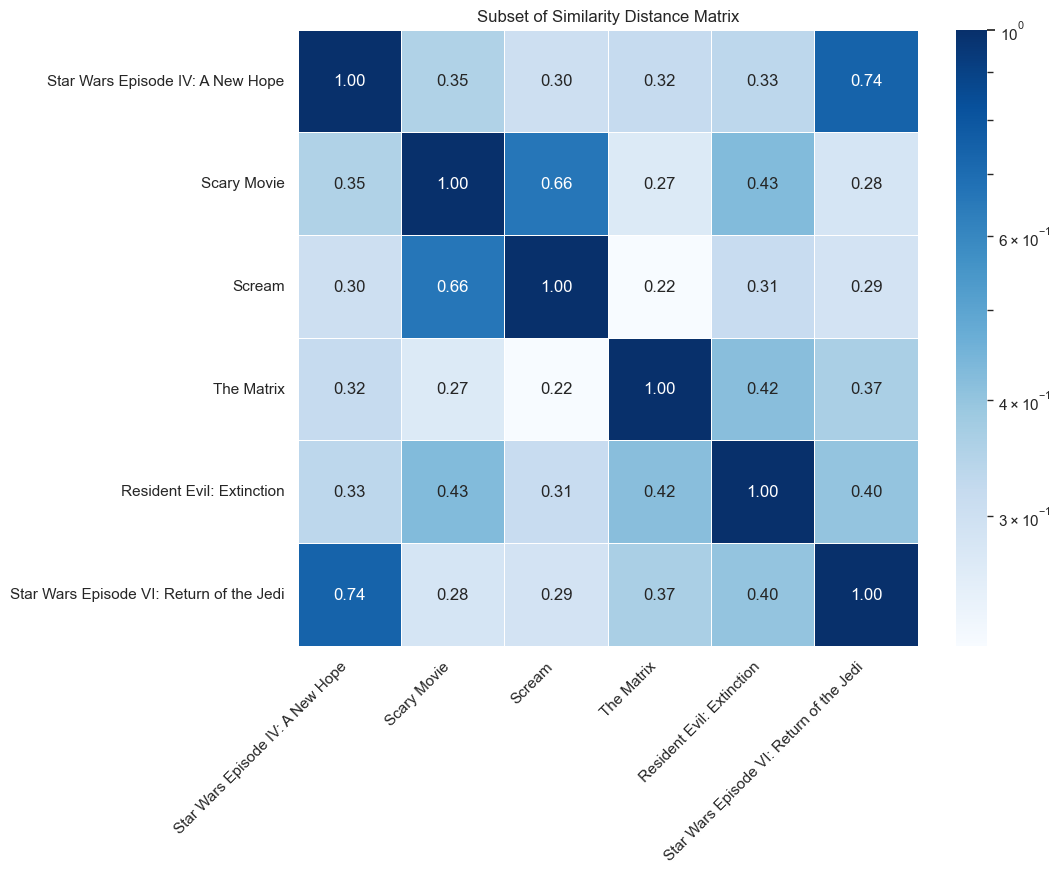

In [85]:
film_names = [
    'Star Wars Episode IV: A New Hope',
    'Star Wars Episode VI: Return of the Jedi',
    'Resident Evil: Extinction',
    'The Matrix',
    'Scary Movie',
    'Scream'
]

similarity_plot(similarity_matrix,merged_df, film_names)


In [86]:
NAME_OF_THE_MOVIE= 'Star Wars'
display( merged_df[merged_df['name'].str.contains(NAME_OF_THE_MOVIE, case=False, na=False)])

,id_wiki,plot,id_freebase,name,year,revenue,runtime,lang,countries,genres
1642,53964,The film begins with an opening crawl explain...,/m/0f3m1,Star Wars Episode V: The Empire Strikes Back,1980,5.383751e+08,124.0,[English Language],[USA],"[Science Fiction, Adventure, Space opera, Fant..."
3429,50957,The Galactic Republic is in turmoil. Followin...,/m/0dfw0,Star Wars Episode II: Attack of the Clones,2002,6.493983e+08,142.0,[English Language],[USA],"[Science Fiction, Adventure, Space opera, Fant..."
3647,52549,The film begins with an opening crawl explain...,/m/0dtfn,Star Wars Episode IV: A New Hope,1977,7.753980e+08,122.0,[English Language],[USA],"[Science Fiction, Adventure, Fantasy, Coming o..."
8019,185264,"It is Life Day . Chewbacca, accompanied by Han...",/m/0199wf,The Star Wars Holiday Special,1978,NaN,97.0,[English Language],[USA],"[Science Fiction, Adventure, Holiday Film, Ani..."
10264,50793,The Galactic Republic is in a period of decli...,/m/0ddt_,Star Wars Episode I: The Phantom Menace,1999,1.027045e+09,136.0,[English Language],[USA],"[Science Fiction, Action, Fantasy, Adventure, ..."
10456,3336298,The special was hosted by C-3PO and R2-D2.{{c...,/m/096gqt,The Making of Star Wars,1977,NaN,50.0,[English Language],[USA],[Documentary]
11747,55447,"As the Clone Wars rage on, the Galactic Repub...",/m/0fdv3,Star Wars Episode III: Revenge of the Sith,2005,8.487548e+08,140.0,[English Language],[USA],"[Science Fiction, Action, Fantasy, Tragedy, Ad..."
13621,50744,Luke Skywalker initiates a plan to rescue Han...,/m/0ddjy,Star Wars Episode VI: Return of the Jedi,1983,4.751062e+08,135.0,[English Language],[USA],"[Science Fiction, Adventure, Space opera, Fant..."
14559,15726696,The Separatists control the majority of the hy...,/m/0cpllql,Star Wars: The Clone Wars,2008,6.828284e+07,90.0,[English Language],[USA],"[Thriller, Science Fiction, Adventure, Compute..."
15695,1861566,"Though a Star Wars fan as a child, life holds ...",/m/061wqh,Saving Star Wars,2004,NaN,117.0,[English Language],[USA],"[Indie, Comedy]"


With this matrix, we can explore interesting features, such as identifying the top 10 most similar films for a given movie. Let's apply this to "Star Wars IV."

In [87]:
given_movie_index = 3647  
max_indices = np.argpartition(similarity_matrix[given_movie_index], -10)[-10:]
given_movie_name = merged_df.iloc[given_movie_index]['name']

print("Given Movie Name:", given_movie_name)
print("Top 10 Most Similar Movie Names:")

for i, index in enumerate(max_indices):
    if index !=given_movie_index:
        movie_name = merged_df.iloc[index]['name']
        print(f"Top {9-i} 🎬: {movie_name}")

Given Movie Name: Star Wars Episode IV: A New Hope
Top 10 Most Similar Movie Names:
Top 9 🎬: Star Wars Episode V: The Empire Strikes Back
Top 8 🎬: Postal
Top 7 🎬: Attack on the Iron Coast
Top 6 🎬: Harry Potter and the Deathly Hallows: Part I
Top 5 🎬: Under Siege 2: Dark Territory
Top 4 🎬: Mom and Dad Save The World
Top 3 🎬: Harry Potter and the Half-Blood Prince
Top 2 🎬: Blood Alley
Top 1 🎬: Star Wars Episode VI: Return of the Jedi


But the most important features to assess the impact of a movie will be to compute the mean similarity before and after:

- Mean similarity before is the average similarity between a given movie and the movie released 7 years before of the same genre
- Mean similarity after is the average similarity between a given movie and the movie released 7 years after of the same genre

Note that we take seven years because we estimated the time to make a movie being approximatively 5 years. Thus add 2 years of errors.

If a movie had a big impact on the industry such that everyone want to copy it the difference between mean similarity before and mean similarity after will be bigger than other film. Of course it only take into account plot and not other aspects of a movie such as special effects, narration, sound effect, etc.. . However it can still confirm if a movie was a source of inspiration for others movie during the trend

Here is the example of Star Wars IV we see that there is a noticeble difference compare to a random film

In [88]:
# Example usage:

film_name = 'Star Wars Episode IV: A New Hope'
movie_index = merged_df[merged_df['name']==film_name].index[0] 
genre='Science Fiction'


mean_similarity_before, mean_similarity_after = calculate_mean_similarity_2(movie_index, merged_df, similarity_matrix, genre)


print(f"The film of '{genre}' released 7 years before '{film_name}' share an average similarity in the plot of  : {mean_similarity_before:.2f}")
print(f"The film of '{genre}' released 7 years after '{film_name}' share an average similarity in the plot of  : {mean_similarity_after:.2f}")


The film of 'Science Fiction' released 7 years before 'Star Wars Episode IV: A New Hope' share an average similarity in the plot of  : 0.22
The film of 'Science Fiction' released 7 years after 'Star Wars Episode IV: A New Hope' share an average similarity in the plot of  : 0.28


We see that Star Wars has an impact on the cinema industry !

# 3) Identification  of pivotal movies

## 3.1) Introduction of the Supervised machine learning

Perfect, we now have every useful metric to determine which film is the most suitable candidate to be pivotal for each trend. We have a metric that assesses the success of a film with revenue, a metric that gauges the popularity of a film with the number of votes and ratings from the website IMDb. Moreover, we consider industry recognition for the film with the number of awards won and the number of nominations for these awards. Finally, we have a metric that evaluates the similarity between the plots of movies to determine if a given film is very similar to the films released during the trend.

The next step is to evaluate the weight of each feature to automate the detection of pivotal movies. To achieve this, we will use a supervised machine learning method. We will train a model by providing the right choice of a pivotal movie for some trends, and then we will test it with the remaining trends we have. However, determining what constitutes a pivotal movie is mostly subjective. Our initial approach was to search for a reputable source on the internet that lists these so-called pivotal movies. After a few hours spent on this searching task, we realized that our work was quite unique. While there are websites that list the most influential movies in cinema history, none of them mention trends in genres. The best approach was then to rely on our cinema knowledge. Since defining a pivotal movie is subjective, we considered it a reasonable approach to include movies that we personally consider pivotal. However, we will discuss this further in the machine learning training section.

Now, let's consider which data points we will use for machine learning. In summary, we will extract data from the `candidates` list to create a DataFrame containing potential pivotal movies with all the desired features. 

## 3.2) Machine Learning Data Extraction

The first step in this machine learning process is to extract data from the `candidates` list. To remind: `candidates` have stored the movies that were released before the trend of the genre. We need to extract all of the candidates and sort them by adding a new column, `trend_genre`, and the number of the trend to recognize from which trend they come. Also, we add an interesting new feature: `year_from_trend`, which is simply how many years the film was released before the starting of the trend. The idea is to penalize movies that were released many years before the trends (e.g., 10 years), as we assume that a movie takes a maximum of 5 years to be produced.


| Feature                    | Description                                                                                                                                                                                |
|----------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Revenue**                | Metric assessing the success of a film based on its revenue.                                                                                                                                |
| **Votes and Ratings**      | Metrics gauging the popularity of a film using the number of votes and ratings from the website IMDb.                                                                                     |
| **Awards Won and Nominations** | Consideration of industry recognition for the film, measured by the number of awards won and the number of nominations for these awards.                                                |
| **Plot Similarity**         | Metric evaluating the similarity between the plots of movies, helping determine if a given film is very similar to the films released during the trend.                                 |
| **Year from Trend**         | The number of years the film was released before the starting of the trend. Introduces a penalty for movies released many years before the trend, assuming a maximum production time of 5 years. |


In [89]:
# CREATION OF DF_CANDIDATES

min_elements = 3 
result_df_double = process_candidates2(candidates_double, min_elements,movies_features,merged_df,similarity_matrix)
result_df = process_candidates(candidates, min_elements,movies_features,merged_df,similarity_matrix)
machine_learning_df=pd.concat([result_df,result_df_double]).reset_index(drop=True)
display(machine_learning_df)

c:\Users\paulr\anaconda3\envs\ada\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\paulr\anaconda3\envs\ada\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\paulr\anaconda3\envs\ada\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\paulr\anaconda3\envs\ada\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\paulr\anaconda3\envs\ada\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\paulr\anaconda3\envs\ada\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar 

,id_wiki,name,year,alt_name,rating,votes,genres,nbr_won,nbr_nomination,revenue_norm,trend_year,trend_number,trend_genre,trend_id,year_from_trend,mean_similarity_before,mean_similarity_after
0,3059075,Brain Donors,1992,Brain Donors,7.1,4100.0,"[Absurdism, Buddy film, Comedy, Slapstick]",0,0,80626.129384,1990,1001,Absurdism,Absurdism of years 1990,-2,0.161371,0.092588
1,1716921,Amazon Women on the Moon,1987,Amazon Women on the Moon,6.2,11932.0,"[Parody, Cult, Science Fiction, Comedy, Absurd...",0,0,59116.397414,1990,1001,Absurdism,Absurdism of years 1990,3,0.184537,0.195372
2,75222,Spaceballs,1987,Spaceballs,7.1,188893.0,"[Parody, Science Fiction, Adventure, Absurdism...",0,0,4106985.482415,1990,1001,Absurdism,Absurdism of years 1990,3,0.253283,0.300951
3,77744,Wayne's World,1992,Wayne's World,7.0,156437.0,"[Buddy film, Absurdism, Cult, Satire, Comedy, ...",0,0,15259089.944132,1990,1001,Absurdism,Absurdism of years 1990,-2,0.273670,0.281478
4,1048388,Hot Shots!,1991,Hot Shots!,6.7,107858.0,"[Parody, Absurdism, Action/Adventure, Comedy, ...",0,0,15822970.103948,1990,1001,Absurdism,Absurdism of years 1990,-1,0.184717,0.257752
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14152,6045886,Up Periscope,1959,Up Periscope,6.4,1962.0,"[Thriller, Combat Films, Drama, War film]",0,0,49403790.144419,1959,626,"Thriller, War film","Thriller, War film of years 1959",0,0.087141,0.091819
14153,5301628,Eye of the Needle,1981,Eye of the Needle,7.1,10691.0,"[Thriller, Crime Fiction, War film, Period pie...",0,0,2349430.018587,1979,627,"Thriller, War film","Thriller, War film of years 1979",-2,0.194508,0.194237
14154,6425079,Who'll Stop the Rain,1978,Who'll Stop the Rain,6.7,2893.0,"[Crime Fiction, Thriller, War film, Action/Adv...",0,0,2039434.151352,1979,627,"Thriller, War film","Thriller, War film of years 1979",1,0.141869,0.164281
14155,12163624,Brass Target,1978,Brass Target,5.9,1236.0,"[Thriller, Adventure, Mystery, Drama, War film...",0,0,1111716.569759,1979,627,"Thriller, War film","Thriller, War film of years 1979",1,0.162975,0.183452


**Problem**

- We observe that `result_df` is not balanced among the trends: some genres like Action or Science Fiction generate more money or are more popular, while some genres share more plot similarity, such as Animation, compared to others.
- Another issue is that in some cases, information about `means_similarity_before` or `means_similarity_after` is missing. This could be due to a missing plot of the movie or the absence of movies of the same genre with a plot 7 years before or after the release of the film.
- Finally, some subsets contain fewer than 3 candidates, making it challenging to make meaningful predictions.

**Solution**

We will address these issues by:

1. Filtering `result_df` to drop all NaN values from similarity features.
2. Keeping only the trends where there are at least 10 candidates.
3. Normalizing the features for each different trend. For example, for a trend in the genre 'Horror,' we will take every feature of the candidate movies, compute the mean and standard deviation, and standardize each feature for this trend.


In [90]:
# FILTERING 

# Now we have the big candidates DataFrame we will Filter the non-interesting trends i.e. trends with less than 3 candidates
filtered_result_df = filter_candidates(machine_learning_df)
display(filtered_result_df)

There are 3062 different movies


,id_wiki,name,year,alt_name,rating,votes,genres,nbr_won,nbr_nomination,revenue_norm,trend_year,trend_number,trend_genre,trend_id,year_from_trend,mean_similarity_before,mean_similarity_after
0,3059075,Brain Donors,1992,Brain Donors,7.1,4100.0,"[Absurdism, Buddy film, Comedy, Slapstick]",0,0,80626.129384,1990,1001,Absurdism,Absurdism of years 1990,-2,0.161371,0.092588
1,1716921,Amazon Women on the Moon,1987,Amazon Women on the Moon,6.2,11932.0,"[Parody, Cult, Science Fiction, Comedy, Absurd...",0,0,59116.397414,1990,1001,Absurdism,Absurdism of years 1990,3,0.184537,0.195372
2,75222,Spaceballs,1987,Spaceballs,7.1,188893.0,"[Parody, Science Fiction, Adventure, Absurdism...",0,0,4106985.482415,1990,1001,Absurdism,Absurdism of years 1990,3,0.253283,0.300951
3,77744,Wayne's World,1992,Wayne's World,7.0,156437.0,"[Buddy film, Absurdism, Cult, Satire, Comedy, ...",0,0,15259089.944132,1990,1001,Absurdism,Absurdism of years 1990,-2,0.273670,0.281478
4,1048388,Hot Shots!,1991,Hot Shots!,6.7,107858.0,"[Parody, Absurdism, Action/Adventure, Comedy, ...",0,0,15822970.103948,1990,1001,Absurdism,Absurdism of years 1990,-1,0.184717,0.257752
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14152,6045886,Up Periscope,1959,Up Periscope,6.4,1962.0,"[Thriller, Combat Films, Drama, War film]",0,0,49403790.144419,1959,626,"Thriller, War film","Thriller, War film of years 1959",0,0.087141,0.091819
14153,5301628,Eye of the Needle,1981,Eye of the Needle,7.1,10691.0,"[Thriller, Crime Fiction, War film, Period pie...",0,0,2349430.018587,1979,627,"Thriller, War film","Thriller, War film of years 1979",-2,0.194508,0.194237
14154,6425079,Who'll Stop the Rain,1978,Who'll Stop the Rain,6.7,2893.0,"[Crime Fiction, Thriller, War film, Action/Adv...",0,0,2039434.151352,1979,627,"Thriller, War film","Thriller, War film of years 1979",1,0.141869,0.164281
14155,12163624,Brass Target,1978,Brass Target,5.9,1236.0,"[Thriller, Adventure, Mystery, Drama, War film...",0,0,1111716.569759,1979,627,"Thriller, War film","Thriller, War film of years 1979",1,0.162975,0.183452


In [91]:
# STANDARDIZATION

# Standardization of the features: we standardize the feature for EACH TRENDS
re = filtered_result_df.copy()
features_to_standardize = ['rating', 'nbr_won','votes', 'nbr_nomination', 'revenue_norm', 'mean_similarity_before','mean_similarity_after']
result_df_standardized = standardize_features(re, features_to_standardize)
display(result_df_standardized)

There are 3062 different movies


,trend_id,level_1,id_wiki,name,year,alt_name,rating,votes,genres,nbr_won,nbr_nomination,revenue_norm,trend_year,trend_number,trend_genre,year_from_trend,mean_similarity_before,mean_similarity_after
0,Absurdism of years 1990,0,3059075,Brain Donors,1992,Brain Donors,0.847998,-1.088884,"[Absurdism, Buddy film, Comedy, Slapstick]",0.0,0.0,-0.857201,1990,1001,Absurdism,-2,-1.261405,-1.964064
1,Absurdism of years 1990,1,1716921,Amazon Women on the Moon,1987,Amazon Women on the Moon,-2.013996,-0.980737,"[Parody, Cult, Science Fiction, Comedy, Absurd...",0.0,0.0,-0.860321,1990,1001,Absurdism,3,-0.807159,-0.570779
2,Absurdism of years 1990,2,75222,Spaceballs,1987,Spaceballs,0.847998,1.462800,"[Parody, Science Fiction, Adventure, Absurdism...",0.0,0.0,-0.273164,1990,1001,Absurdism,3,0.540820,0.860396
3,Absurdism of years 1990,3,77744,Wayne's World,1992,Wayne's World,0.529999,1.014637,"[Buddy film, Absurdism, Cult, Satire, Comedy, ...",0.0,0.0,1.344486,1990,1001,Absurdism,-2,0.940566,0.596434
4,Absurdism of years 1990,4,1048388,Hot Shots!,1991,Hot Shots!,-0.423999,0.343841,"[Parody, Absurdism, Action/Adventure, Comedy, ...",0.0,0.0,1.426279,1990,1001,Absurdism,-1,-0.803638,0.274813
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12001,Zombie Film of years 1980,4553,1802400,Phantasm,1979,Phantasm,0.000000,0.018298,"[Cult, Zombie Film, Horror, Slasher, Supernatu...",0.0,0.0,-0.058512,1980,1385,Zombie Film,1,-0.642373,-1.169125
12002,Zombie Film of years 2002,4555,3238135,House of the Dead,2003,House of the Dead,-1.650452,-0.863374,"[Thriller, Horror, World cinema, Action/Advent...",0.0,0.0,-0.816298,2002,1386,Zombie Film,-1,-0.403399,-0.019800
12003,Zombie Film of years 2002,4556,538455,Dawn of the Dead,2004,Dawn of the Dead,0.750205,0.470276,"[Thriller, Science Fiction, Horror, Doomsday f...",0.0,0.0,1.320653,2002,1386,Zombie Film,-2,0.978158,0.880687
12004,Zombie Film of years 2002,4557,145892,28 Days Later,2002,28 Days Later...,0.842538,1.412313,"[Thriller, Science Fiction, Horror, Doomsday f...",0.0,0.0,0.602909,2002,1386,Zombie Film,0,-1.452563,0.764009


 ## 3.3) Training 

Now that we have `result_df` with all potential pivotal movie candidates, we need to select some movies that we consider pivotal. As mentioned previously, there is no objective way to do this, so we will delve into the trends and choose movies that we deem pivotal. Subsequently, we need to choose some movies that are not pivotal. To achieve this, we will create a list of candidates where we choose the pivotal movies and then consider other movies in this list as non-pivotal.

Even though this source doesn't mention trend generation, we will use the IMDb ranking of the most influential movies, specifically the [IMDb Top 100 of Most Influential Movies](https://www.imdb.com/list/ls000656362/), to train the model.

*Remark*: Before proceeding with the machine learning using this training set, we need to split this training set and retain some guessed pivotal movies to assess if the machine learning will correctly identify and consider them as pivotal. This step serves as confirmation that the model is well-trained and accurate.


The choosen movie for the training are the following ones :
  
- **STAR WARS IV: A New Hope**
  - *Genre*: Science Fiction
- **THE KARATE KID**
  - *Genre*: Martial Arts Film
- **TOY STORY**
  - *Genre*: Computer Animation
- **THE SEARCHERS**
  - *Genre*: Epic Western
- **BONNIE AND CLYDE**
  - *Genre*: Gangster Film
- **PHILADELPHIA**
  - *Genre*: Gay
- **PULP FICTION**
  - *Genre*: Crime Comedy
- **THE LION KING**
  - *Genre*: Animation
- **THE EXORCIST**
  - *Genre*: Horror
- **THE SHINING**
  - *Genre*: Psychological thriller
- **TITANIC**
  - *Genre*: Tragedy
- **ALIEN**
  - *Genre*: Creature Film


In [92]:
training_points, labels=training (result_df_standardized)
features_name =  ['rating', 'nbr_won','votes', 'nbr_nomination', 'revenue_norm', 'mean_similarity_before','mean_similarity_after','year_from_trend']

In [93]:
logistic=perform_logistic_regression(training_points, labels, features_name)

Coefficents: 

rating: -0.05724
nbr_won: 0.49399
votes: 0.84619
nbr_nomination: 0.31206
revenue_norm: 0.77538
mean_similarity_before: 1.03938
mean_similarity_after: 0.42172
year_from_trend: 0.32332

 Intercept: -5.79693



The cell above displays the coefficients of the logistic regression for each feature. The intercept represents the log-likelihood that a film with all the chosen features set to zero is considered pivotal. The coefficients indicate the weight of each feature in determining the pivotal score.

In this case:

- The intercept has a large negative value, indicating that a film with a score of 0 in every feature will have a very low probability of being pivotal.
- The coefficients show the importance of each feature. For example, the feature "votes" has the largest coefficient, implying that, all else being equal, if film A has one more vote than film B, and film B has a higher standardized review feature by one compared to film A, film A will have a higher probability of being pivotal. The coefficients help us understand the relative importance of each feature in determining whether a film is pivotal.



## 3.4) Results

After verifying that the machine learning model works correctly, we can finally answer our project question: Which movies are pivotal?

The machine learning model computes the score of each film for each trend and selects the one with the highest log-likelihood as the pivotal film for the given trend.

And the moment we've all been waiting for... 🥁🥁🥁 The list of pivotal movies is...


In [94]:
pivotal_mov, most_likely_indices,all_probabilities =find_most_likely_pivotal_movie(result_df_standardized, logistic)
display(pivotal_mov)

Trend Absurdism of years 1990  : Most Likely Pivotal Movie - Spaceballs
Trend Action Thrillers of years 1967  : Most Likely Pivotal Movie - Bullitt
Trend Action Thrillers of years 1987  : Most Likely Pivotal Movie - Rambo First Blood Part II
Trend Action Thrillers, Action/Adventure of years 1987  : Most Likely Pivotal Movie - Rambo First Blood Part II
Trend Action Thrillers, Crime Fiction of years 1967  : Most Likely Pivotal Movie - Bullitt
Trend Action Thrillers, Crime Fiction of years 1985  : Most Likely Pivotal Movie - Octopussy
Trend Action Thrillers, Drama of years 1966  : Most Likely Pivotal Movie - Bullitt
Trend Action Thrillers, Thriller of years 1967  : Most Likely Pivotal Movie - Bullitt
Trend Action Thrillers, Thriller of years 1988  : Most Likely Pivotal Movie - First Blood
Trend Action of years 1967  : Most Likely Pivotal Movie - Lawrence of Arabia
Trend Action, Action Thrillers of years 1967  : Most Likely Pivotal Movie - Bullitt
Trend Action, Action Thrillers of years 19

,name,id_wiki,trend_genre,trend_id
0,Spaceballs,75222,Absurdism,Absurdism of years 1990
1,Bullitt,433285,Action Thrillers,Action Thrillers of years 1967
2,Rambo First Blood Part II,583012,Action Thrillers,Action Thrillers of years 1987
3,Rambo First Blood Part II,583012,"Action Thrillers, Action/Adventure","Action Thrillers, Action/Adventure of years 1987"
4,Bullitt,433285,"Action Thrillers, Crime Fiction","Action Thrillers, Crime Fiction of years 1967"
...,...,...,...,...
606,The Bridge on the River Kwai,42856,War film,War film of years 1957
607,The Treasure of the Sierra Madre,11088642,Western,Western of years 1947
608,The Hudsucker Proxy,170858,Workplace Comedy,Workplace Comedy of years 1995
609,Dawn of the Dead,65436,Zombie Film,Zombie Film of years 1980


# 4) Visualization of the Results

 Before analysing the result let's illustrate the results we got by doing some cool visualizeation.


## 4.1) Pivotals in Graphs

We can gather the final results computed before:

In [95]:
pivotals_simple = pivotal_mov[pivotal_mov['trend_genre'].apply(lambda x: ',' not in x)]
pivotals_double = pivotal_mov[pivotal_mov['trend_genre'].apply(lambda x: ',' in x)]
pivotals_double.loc[:,'trend_genre'] = pivotals_double['trend_genre'].apply(lambda x: tuple(x.split(', ')))

In [96]:
show_pivotal(pivotals_simple, movies, 1)
show_pivotal(pivotals_double, movies, 1)

==== PIVOTAL MOVIE ====
For genre Action Thrillers of the trend peak 1967
	🏆🏆 >> PIVOTAL IS Bullitt (1968)

==== PIVOTAL MOVIE ====
For genre ('Action Thrillers', 'Crime Fiction') of the trend peak 1967
	🏆🏆 >> PIVOTAL IS Bullitt (1968)



Let's see how the pivotals we detected look on the graph. You can change the genre name to switch between visualizations of subsets.

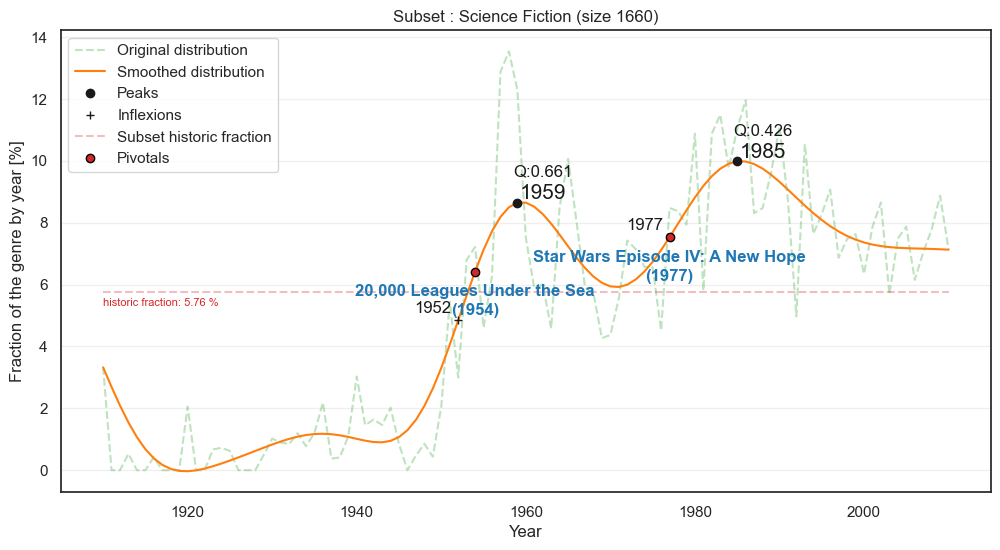

In [97]:
key = 'Science Fiction'
fig = get_pivotals_simple(movies, subsets, pivotals_simple, key)

Same visualization, but for subsets of double genres.

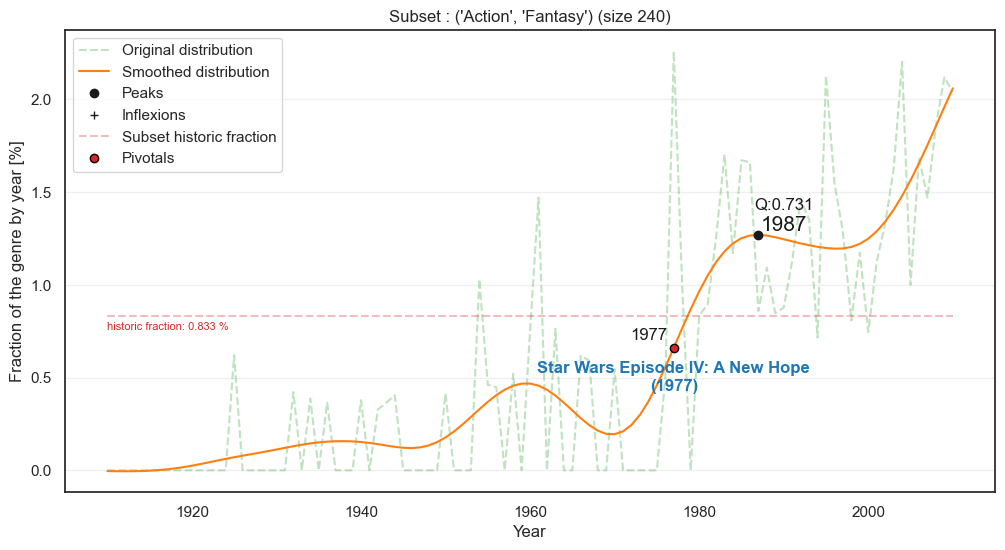

In [98]:
fig = get_pivotals_double(movies, subsets_double, pivotals_double, 'Action', 'Fantasy')

We can save all pivotals visualizations as images by running the code below.

## 4.2) Top Pivotal movies

As mentioned earlier, the machine learning model provides us with the movie with the highest logistic score in every trend. Now, let's visualize which movies have the best score without taking into account trends. This will help us identify the films that are most likely to be pivotal in cinematic history.



In [100]:
# Define the movies to exclude
movies_to_exclude = [
    'Star Wars Episode IV A New Hope',
    'The Karate Kid',
    'Toy Story',
    'THE Searchers',
    'Bonnie and Clyde',
    'Philadelphia',
    'Pulp Fiction',
    'The Lion King',
    'The Exorcist',
    'The Shinning',
    'Titanic',
    'Aliens'
]

# Find the indices of the movies ranked from 30th to 50th highest probabilities excluding specified movies
selected_indices = [i for i in sorted(range(len(all_probabilities)), key=lambda i: all_probabilities[i], reverse=True)[0:61] if result_df_standardized.iloc[i]['name'] not in movies_to_exclude]

# Keep track of selected movie names and the count
selected_movie_names = set()
movies_printed = 0

# Get the details of the selected movies
selected_movies = result_df_standardized.iloc[selected_indices]

# Print the names and probabilities of the selected movies
print("Top 20 movies with highest Probabilities (Excluding Training Movies):\n")
for index, movie_info in selected_movies.iterrows():
    movie_name = movie_info['name']
    if movie_name not in selected_movie_names:
        print(f"{movie_name} (for trend {movie_info['trend_id']}) (Probability: {all_probabilities[index]:.4f})")
        selected_movie_names.add(movie_name)
        movies_printed += 1


Top 20 movies with highest Probabilities (Excluding Training Movies):

The Silence of the Lambs (for trend Crime Thriller of years 1989) (Probability: 1.0000)
Forrest Gump (for trend Coming of age of years 1995) (Probability: 0.9999)
Lawrence of Arabia (for trend Action/Adventure of years 1966) (Probability: 0.9999)
Jurassic Park (for trend Action, Horror of years 2000) (Probability: 0.9999)
Doctor Zhivago (for trend Drama, Romantic drama of years 1977) (Probability: 0.9999)
Platoon (for trend Drama, Indie of years 1994) (Probability: 0.9999)
Jerry Maguire (for trend Drama, Sports of years 1997) (Probability: 0.9999)
Gone with the Wind (for trend Costume drama of years 1949) (Probability: 0.9999)
The Untouchables (for trend Action, Crime Thriller of years 1992) (Probability: 0.9998)
Fargo (for trend Comedy, Indie of years 1995) (Probability: 0.9997)
Back to the Future (for trend Adventure, Family Film of years 1991) (Probability: 0.9996)
Born on the Fourth of July (for trend Political 

It appears that some of the movies (9 movies out of 20) of our top 20 identified as pivotal in our analysis are also present in the [IMDb Top 100 of Most Influential Movies](https://www.imdb.com/list/ls000656362/). The overlapping movies include:

- **2001 A Space Odyssey**
- **Lawrence of Arabia**
- **The Silence of the Lambs**
- **Forrest Gump**
- **Doctor Zhivago**
- **Butch Cassidy and the Sundance Kid**
- **Platoon**
- **Schindler's List**
- **Gone with the Wind**

This alignment between our results and the IMDb list adds credibility to our findings and serves as a validation of the identified pivotal films. 


## 4.3) Similarity network

Having pivotal movie is cool but visualize it is better . We will build as small network with film being nodes and edge plot similarity between film. The idea is to see if  most successful movie in term of revenue have big similarity with the pivotal movie. To that we will select movies that were realeased on a interval of two years before and 7 years after the movie to see if the pivotal movie share many plot similarty with successfull movie of the same trend. It can confirm in some case that film liked by the public are inspired by our pivotal movie. Then the pivotal movie produce this trend. 

### Pivotal Movie Influence: The Incredible Melting Man

In the analysis of pivotal movies, we can observe the inspirational impact that a pivotal movie can have on other successful films within a specific genre. Let's take a closer look at the example of "The Incredible Melting Man," identified as a pivotal film for the Sci-Fi Horror trend of 1975.

### Network Graph Visualization

In the following network graph:

- **Node Size:** Represents the median of the similarity score.
- **Edge Color:** Indicates the plot similarity between two films (bluer edges represent higher similarity).
- **Node Color:** Purple node (center) represents the pivotal film for the Sci-Fi Horror trend of 1975.



#### Observations:

- The central purple node has the largest size, signifying the highest median similarity score with other successful films in the same genre.
- The network structure demonstrates how this pivotal film has influenced and inspired other films within the Sci-Fi Horror trend of 1975.

This visualization provides insights into the significant role of "The Incredible Melting Man" in shaping the cinematic landscape within its genre during the specified trend.


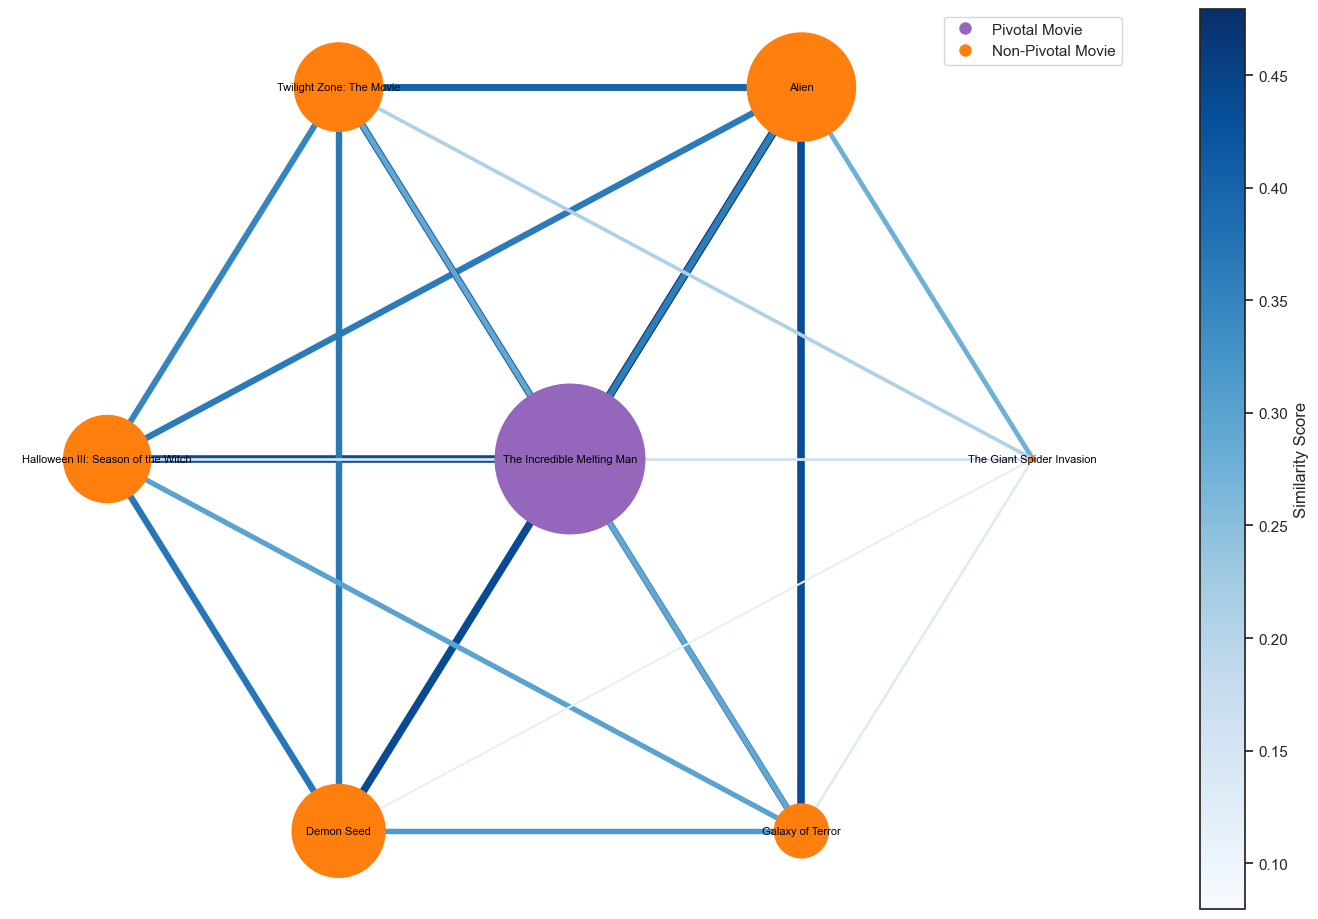

In [101]:
from helpers import *
name_of_the_pivotal_movie= 'The Incredible Melting Man'
genre_of_the_trend = ('Sci-Fi Horror',)	

viz_network(name_of_the_pivotal_movie,genre_of_the_trend,merged_df,movies_features,pivotal_mov,similarity_matrix,df_plot)

But is it not always the case sometimes pivotal movie is share not the most similarity with other film realeased after in the same genre for example Amadeus in the trend Biography and Period piece of 1990 

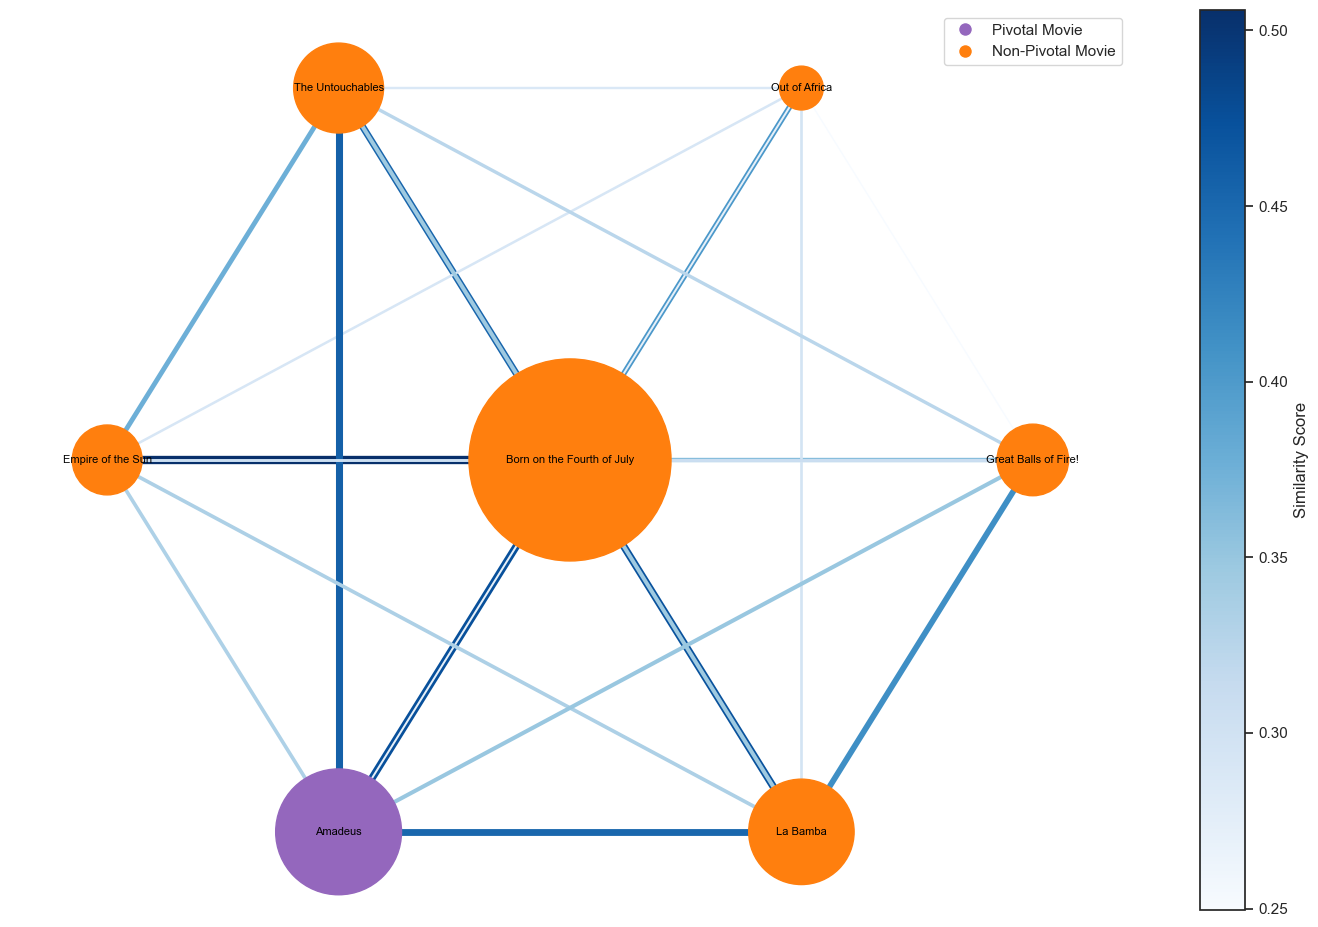

In [102]:
from helpers import *
name_of_the_pivotal_movie= 'Amadeus'
genre_of_the_trend = ('Biography', 'Period piece')	

viz_network(name_of_the_pivotal_movie,genre_of_the_trend,merged_df,movies_features,pivotal_mov,similarity_matrix,df_plot)

#### Observations:

- The central node representing "Amadeus" is large, indicating a high median similarity score with other successful films.
- While it may not always share the most similarity with films released after it in the same genre, the high median score signifies its significant influence within the Biography and Period Piece trend of 1990.
- The network structure illustrates the diverse connections and impact that "Amadeus" has had on subsequent films, showcasing its  influence over time.

This visualization helps then understanding better the impact of a pivotal film in the plot of other successfull film released after the pivotal one.

# Conclusion 

We have successfully designed a method, which allows us to identify pivotal movies (movies that produced a trend in cinema industry). The fact that some of our best findings are present in lists such as the IMDb “100 best movies of all time” confirms, that our analysis has the power to be successful. Ideally, some more code tweaking and the addition of more metrics could lead to a very powerful tool, which can deliver interesting insights into the history of the cinematic universe. 

Whether these movies are the Pivotal Movies, that really were the triggering element of the historical trends in the movie industry cannot be determined for sure. The term Pivotal Movie cannot be broken down onto a clearly defined number of traits, as it is a conceptual idea. TheWestBobers approach was to assume that the most “successful” movie (based on different metrics that are a mix of industry, financial, and public aspects) in a trend (defined by a time window and a genre / double-genre constraint) is the most likely to be pivotal.

**Limitations** :

A purely data based analysis and a very limited number of metrics are leading to major limitations of the outcome:
- Our analysis looks at the inflection points of the smoothed genre fraction signal. The problem is that if we had chosen another signal processing algorithm, we could have had slightly different dates for the inflections, so this could be a flaw in our method.
- Some genres are too vague, and many films are classified as such (e.g. Comedy, Fantasy), so the pivotal points we find may not be representative of the genre. For this, we'd need to make a more precise analysis that goes beyond the genre, but takes into account the themes addressed in the film (e.g. Comedy-"high school", Science Fiction-"spaceship").
- We also assume that a trend is always caused by a film, but some trends are in fact caused by external elements.
- We assume that the shape of a trend always stands out, with a noticeable inflection point, but we've noticed that some trends don't always have this shape, so our results aren't necessarily the best (e.g. Crime Fiction peak of 1948).

